<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Ames Housing Data and Kaggle Challenge


## Problem Statement

We are consultants hired by A real estate developer, researching on what factors impact the sale price most


how to allocate resources to improve participation rates and/or scores for SAT and/or ACT in the United States.
In this project, we intend to evaluate if there is a ACT score bias for households with higher or lower median income. Specifically, we will explore the association of statewide ACT mean score and median family income, and try to establish a linear regression model between them


### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [export data](#Exporting-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hypothesis Test](#Hypothesis-Test)
- [Linear regression model](#Linear-regression-model)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Data Visualization](#Visualize-the-Data)

## Background

# Import libraries

In [149]:
# Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoCV, RidgeCV,Ridge,Lasso
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,PolynomialFeatures


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer



import copy

get_ipython().run_line_magic('matplotlib', 'inline')


pd.options.display.max_columns = None
pd.options.display.max_rows = None


is_delete_outliers = False



# define some functions

In [150]:
def plot_features_numeric(df,x_columns, y_column):
    fig, axs = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for i in range(len(x_columns)):
        sns.histplot(data=df, x=x_columns[i], kde=True, color="skyblue", ax=axs[i])
    sns.pairplot(df, x_vars=x_columns, y_vars=y_column)

In [151]:
def plot_features_catagorical(df,x_columns, y_column):
    fig, axs = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for i in range(len(x_columns)):
        sns.histplot(data=df, x=x_columns[i], kde=False, color="skyblue", ax=axs[i])
    
    fig2, axs2 = plt.subplots(1, len(x_columns),constrained_layout=True, figsize=(12,3))
    for j in range(len(x_columns)):
         sns.boxplot(x=x_columns[j], y=y_column, data=df, ax=axs2[j])
    

In [152]:
def proccess_outliers_IQR(df, feature, cut_off_IQR, direction="both", flag="delete"):
    print("feature name:", feature)
    # calculate interquartile range
    q25, q75 = df[feature].quantile(0.25), df[feature].quantile(0.75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * cut_off_IQR
    lower, upper = q25 - cut_off, q75 + cut_off
    
    if direction == 'both':
        # identify outliers
        outliers_lower = df[(df[feature] <= lower)].values
        outliers_upper =  df[(df[feature]>= upper)].values
        print('Identified outliers: %d' 
          % (len(outliers_lower)+ len(outliers_upper))
         )
        if flag == "delete":
            out = df[(df[feature]<= lower) | (df[feature]>=upper)].index
            df.drop(out, inplace=True)
            print("deleted the outliers")
        elif flag == 'replace':
            df[feature].replace(outliers_lower, lower, inplace=True)
            df[feature].replace(outliers_upper, upper, inplace=True)
            print("replaced the outliers")
        else:
            print("did not process the outliers")
    elif direction == 'lower':
        # identify outliers
        outliers_lower = df[(df[feature] <= lower)].values
        print('Identified outliers: %d' % (len(outliers_lower)))

        if flag == "delete":
            out = df[(df[feature]<= lower)].index
            df.drop(out, inplace=True)
            print("deleted the outliers")
        elif flag == 'replace':
            df[feature].replace(outliers_lower, lower, inplace=True)
            print("replaced the outliers")
        else:
            print("did not process the outliers")
    elif direction == 'upper':
        outliers_upper =  df[(df[feature]>= upper)].values
        print('Identified outliers: %d' % (len(outliers_upper)))
        
        if flag == "delete":
            out = df[(df[feature]>=upper)].index
            df.drop(out, inplace=True)
            print("deleted the outliers")
        elif flag == 'replace':
            df[feature].replace(outliers_upper, upper, inplace=True)
            print("replaced the outliers")
        else:
            print("did not process the outliers")
    else:
        print("did not process the outliers")
        

In [153]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

## Data Import and Cleaning
- to avoid repeating work, we will concatenate datasets from 'train.csv' and 'test.cvs'
- we will 

In [154]:
# read the files
df_train = pd.read_csv("../datasets/train.csv")
df_train['source'] = 'train'
print("shape of 'train.csv'", df_train.shape)

df_test = pd.read_csv("../datasets/test.csv")
df_test['source'] = 'test'
print("shape of 'test.csv'", df_test.shape)

df = pd.concat([df_train,df_test], ignore_index = True, sort = False)

print("shape of 'df'", df.shape)
df.head().T

shape of 'train.csv' (2051, 82)
shape of 'test.csv' (878, 81)
shape of 'df' (2929, 82)


0          1          2          3          4
Id                     109        544        153        318        255
PID              533352170  531379050  535304180  916386060  906425045
MS SubClass             60         60         20         60         50
MS Zoning               RL         RL         RL         RL         RL
Lot Frontage           NaN       43.0       68.0       73.0       82.0
Lot Area             13517      11492       7922       9802      14235
Street                Pave       Pave       Pave       Pave       Pave
Alley                  NaN        NaN        NaN        NaN        NaN
Lot Shape              IR1        IR1        Reg        Reg        IR1
Land Contour           Lvl        Lvl        Lvl        Lvl        Lvl
Utilities           AllPub     AllPub     AllPub     AllPub     AllPub
Lot Config         CulDSac    CulDSac     Inside     Inside     Inside
Land Slope             Gtl        Gtl        Gtl        Gtl        Gtl
Neighborhood        Sawyer    SawyerW      NAmes     Timber    SawyerW
Condition 1           RRAe       Norm       Norm       Norm       Norm
Condition 2           Norm       Norm       Norm       Norm       Norm
Bldg Type             1Fam       1Fam       1Fam       1Fam       1Fam
House Style         2Story     2Story     1Story     2Story     1.5Fin
Overall Qual             6          7          5          5          6
Overall Cond             8          5          7          5          8
Year Built            1976       1996       1953       2006       1900
Year Remod/Add        2005       1997       2007       2007       1993
Roof Style           Gable      Gable      Gable      Gable      Gable
Roof Matl          CompShg    CompShg    CompShg    CompShg    CompShg
Exterior 1st       HdBoard    VinylSd    VinylSd    VinylSd    Wd Sdng
Exterior 2nd       Plywood    VinylSd    VinylSd    VinylSd    Plywood
Mas Vnr Type       BrkFace    BrkFace       None       None       None
Mas Vnr Area         289.0      132.0        0.0        0.0        0.0
Exter Qual              Gd         Gd         TA         TA         TA
Exter Cond              TA         TA         Gd         TA         TA
Foundation          CBlock      PConc     CBlock      PConc      PConc
Bsmt Qual               TA         Gd         TA         Gd         Fa
Bsmt Cond               TA         TA         TA         TA         Gd
Bsmt Exposure           No         No         No         No         No
BsmtFin Type 1         GLQ        GLQ        GLQ        Unf        Unf
BsmtFin SF 1         533.0      637.0      731.0        0.0        0.0
BsmtFin Type 2         Unf        Unf        Unf        Unf        Unf
BsmtFin SF 2           0.0        0.0        0.0        0.0        0.0
Bsmt Unf SF          192.0      276.0      326.0      384.0      676.0
Total Bsmt SF        725.0      913.0     1057.0      384.0      676.0
Heating               GasA       GasA       GasA       GasA       GasA
Heating QC              Ex         Ex         TA         Gd         TA
Central Air              Y          Y          Y          Y          Y
Electrical           SBrkr      SBrkr      SBrkr      SBrkr      SBrkr
1st Flr SF             725        913       1057        744        831
2nd Flr SF             754       1209          0        700        614
Low Qual Fin SF          0          0          0          0          0
Gr Liv Area           1479       2122       1057       1444       1445
Bsmt Full Bath         0.0        1.0        1.0        0.0        0.0
Bsmt Half Bath         0.0        0.0        0.0        0.0        0.0
Full Bath                2          2          1          2          2
Half Bath                1          1          0          1          0
Bedroom AbvGr            3          4          3          3          3
Kitchen AbvGr            1          1          1          1          1
Kitchen Qual            Gd         Gd         Gd         TA         TA
TotRms AbvGrd            6          8          5 

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2929 non-null   int64  
 1   PID              2929 non-null   int64  
 2   MS SubClass      2929 non-null   int64  
 3   MS Zoning        2929 non-null   object 
 4   Lot Frontage     2439 non-null   float64
 5   Lot Area         2929 non-null   int64  
 6   Street           2929 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2929 non-null   object 
 9   Land Contour     2929 non-null   object 
 10  Utilities        2929 non-null   object 
 11  Lot Config       2929 non-null   object 
 12  Land Slope       2929 non-null   object 
 13  Neighborhood     2929 non-null   object 
 14  Condition 1      2929 non-null   object 
 15  Condition 2      2929 non-null   object 
 16  Bldg Type        2929 non-null   object 
 17  House Style   

### after comparing the data directory and dataframe Dtypes, and found the following columns need to convert to string type
- id
- pid
- ms_subclass

In [156]:
#rename column
#df.columns=df.columns.str.lower()
#df.columns=df.columns.str.replace(" ","_")
#change column type, according to data directory

df["Id"]=df["Id"].astype("str")
df["PID"]=df["PID"].astype("str")
df["MS SubClass"]=df["MS SubClass"].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2929 non-null   object  
 1   PID              2929 non-null   object  
 2   MS SubClass      2929 non-null   category
 3   MS Zoning        2929 non-null   object  
 4   Lot Frontage     2439 non-null   float64 
 5   Lot Area         2929 non-null   int64   
 6   Street           2929 non-null   object  
 7   Alley            198 non-null    object  
 8   Lot Shape        2929 non-null   object  
 9   Land Contour     2929 non-null   object  
 10  Utilities        2929 non-null   object  
 11  Lot Config       2929 non-null   object  
 12  Land Slope       2929 non-null   object  
 13  Neighborhood     2929 non-null   object  
 14  Condition 1      2929 non-null   object  
 15  Condition 2      2929 non-null   object  
 16  Bldg Type        2929 non-null   object  


In [157]:
features_categorical = [
       'MS SubClass', 'Sale Type', 'Misc Feature','Garage Type','Central Air','Heating','Foundation', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Lot Config', 'Land Contour',
       'Alley', 'Street', 'MS Zoning'
]


features_ordinal = [
       'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical',  'Heating QC', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Exter Cond', 'Exter Qual',
       'Land Slope', 'Utilities',
       'Lot Shape','Overall Qual', 'Overall Cond'
]


features_numeric = [
        'Lot Frontage', 'Lot Area', 
       'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold', 'Yr Sold'
]

#print(features_numeric)
df[features_categorical]=df[features_categorical].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Id               2929 non-null   object  
 1   PID              2929 non-null   object  
 2   MS SubClass      2929 non-null   category
 3   MS Zoning        2929 non-null   category
 4   Lot Frontage     2439 non-null   float64 
 5   Lot Area         2929 non-null   int64   
 6   Street           2929 non-null   category
 7   Alley            198 non-null    category
 8   Lot Shape        2929 non-null   object  
 9   Land Contour     2929 non-null   category
 10  Utilities        2929 non-null   object  
 11  Lot Config       2929 non-null   category
 12  Land Slope       2929 non-null   object  
 13  Neighborhood     2929 non-null   category
 14  Condition 1      2929 non-null   category
 15  Condition 2      2929 non-null   category
 16  Bldg Type        2929 non-null   category


#rearrange the columns such that all feature of 'object' type will be moved before all numeric 

df2=pd.DataFrame()
columns_copy = df.columns.tolist()[2:]
for column in columns_copy:
    if df[column].dtype == object:
        column_to_reorder = df.pop(column)
        df.insert(3, column, column_to_reorder)
        df[column] = df[column].astype('category')
   # else:
    #    df2.insert(-1, df.columns[i], column_to_reorder)
df.info()

In [158]:
print("from above, we can see: column #2 to #44 are of catagorical features  ")
print("from above, we can see: column #44 and above are of numeric features  ")

from above, we can see: column #2 to #44 are of catagorical features  
from above, we can see: column #44 and above are of numeric features  




features_catagorical = df.select_dtypes(include='category').columns
print(features_catagorical)

features_numeric = df.select_dtypes(include='number').columns
print(features_numeric)

## checking null values

In [159]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)

Pool QC            0.995562
Misc Feature       0.963810
Alley              0.932400
Fence              0.804712
Fireplace Qu       0.485490
SalePrice          0.299761
Lot Frontage       0.167293
Garage Finish      0.054285
Garage Qual        0.054285
Garage Yr Blt      0.054285
Garage Cond        0.054285
Garage Type        0.053602
Bsmt Exposure      0.028337
BsmtFin Type 2     0.027654
Bsmt Cond          0.027313
Bsmt Qual          0.027313
BsmtFin Type 1     0.027313
Mas Vnr Area       0.007853
Mas Vnr Type       0.007853
Bsmt Full Bath     0.000683
Bsmt Half Bath     0.000683
Garage Area        0.000341
BsmtFin SF 1       0.000341
Electrical         0.000341
Total Bsmt SF      0.000341
Bsmt Unf SF        0.000341
BsmtFin SF 2       0.000341
Garage Cars        0.000341
Full Bath          0.000000
Half Bath          0.000000
Bedroom AbvGr      0.000000
Kitchen AbvGr      0.000000
Kitchen Qual       0.000000
TotRms AbvGrd      0.000000
Sale Type          0.000000
Yr Sold            0

we will not consider the following features with too many null value:

|feature|null value %|
------------------------------
Pool QC            0.995612

Misc Feature       0.968308

Alley              0.931741

Fence              0.804973

Fireplace Qu       0.487567

Lot Frontage       0.160897

In [160]:
features_numeric.remove('Lot Frontage')
df.drop(columns=['Lot Frontage'],inplace=True)
print(features_numeric)

['Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold']


In [161]:
features_categorical.remove('Misc Feature')
features_categorical.remove('Alley')
features_ordinal.remove('Pool QC')
features_ordinal.remove('Fence')
features_ordinal.remove('Fireplace Qu')

df.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'],inplace=True)

print(features_categorical)
print(features_ordinal)

['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Neighborhood', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']
['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape', 'Overall Qual', 'Overall Cond']


In [162]:
df.isnull().sum().sort_values(ascending=False)

SalePrice          878
Garage Cond        159
Garage Yr Blt      159
Garage Finish      159
Garage Qual        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Area          1
Garage Cars          1
Electrical           1
Id                   0
Kitchen AbvGr        0
Half Bath            0
Full Bath            0
Bedroom AbvGr        0
Functional           0
Kitchen Qual         0
TotRms AbvGrd        0
Low Qual Fin SF      0
Fireplaces           0
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
Sale Type            0
Gr Liv Area

#### impute zero for numeric columns

In [163]:
df[features_numeric].isnull().sum().sort_values(ascending=False)

Garage Yr Blt      159
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
Lot Area             0
3Ssn Porch           0
Screen Porch         0
Misc Val             0
Mo Sold              0
Pool Area            0
Bedroom AbvGr        0
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Year Built           0
Half Bath            0
Full Bath            0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Year Remod/Add       0
Yr Sold              0
dtype: int64

In [164]:
df.loc[:,features_numeric]=df[features_numeric].fillna(0)
df[features_numeric].isnull().sum().sort_values(ascending=False)

Lot Area           0
Year Built         0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Garage Area        0
Garage Cars        0
Garage Yr Blt      0
Fireplaces         0
TotRms AbvGrd      0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 2       0
BsmtFin SF 1       0
Mas Vnr Area       0
Year Remod/Add     0
Yr Sold            0
dtype: int64

### imputing ordinal features


In [165]:
df[features_ordinal].isnull().sum().sort_values(ascending=False)

Garage Qual       159
Garage Finish     159
Garage Cond       159
Bsmt Exposure      83
BsmtFin Type 2     81
BsmtFin Type 1     80
Bsmt Cond          80
Bsmt Qual          80
Electrical          1
Exter Qual          0
Overall Qual        0
Lot Shape           0
Utilities           0
Land Slope          0
Paved Drive         0
Exter Cond          0
Heating QC          0
Kitchen Qual        0
Functional          0
Overall Cond        0
dtype: int64

In [166]:
df['Garage Qual']=df['Garage Qual'].fillna("NA")
df['Garage Finish']=df['Garage Finish'].fillna("NA")
df['Garage Cond']=df['Garage Cond'].fillna("NA")
df['Bsmt Exposure']=df['Bsmt Exposure'].fillna("NA")
df['BsmtFin Type 2']=df['BsmtFin Type 2'].fillna("NA")
df['BsmtFin Type 1']=df['BsmtFin Type 1'].fillna("NA")
df['Bsmt Cond']=df['Bsmt Cond'].fillna("NA")
df['Bsmt Qual']=df['Bsmt Qual'].fillna("NA")
df['Electrical']=df['Electrical'].fillna("Mix")

df[features_ordinal].isnull().sum().sort_values(ascending=False)

Paved Drive       0
Garage Cond       0
Overall Qual      0
Lot Shape         0
Utilities         0
Land Slope        0
Exter Qual        0
Exter Cond        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Heating QC        0
Electrical        0
Kitchen Qual      0
Functional        0
Garage Finish     0
Garage Qual       0
Overall Cond      0
dtype: int64

### imputing categorical features

In [167]:
df[features_categorical].isnull().sum().sort_values(ascending=False)

Garage Type     157
Mas Vnr Type     23
MS SubClass       0
House Style       0
Street            0
Land Contour      0
Lot Config        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
Roof Style        0
Sale Type         0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Foundation        0
Heating           0
Central Air       0
MS Zoning         0
dtype: int64

In [168]:
df['Garage Type'].value_counts(dropna=False)

Attchd     1731
Detchd      782
BuiltIn     185
NaN         157
Basment      36
2Types       23
CarPort      15
Name: Garage Type, dtype: int64

In [169]:
df['Garage Type']=df['Garage Type'].astype('object')
df['Garage Type']=df['Garage Type'].fillna("NA")
df['Garage Type']=df['Garage Type'].astype('category')
df['Mas Vnr Type']=df['Mas Vnr Type'].fillna("None")
df[features_categorical].isnull().sum().sort_values(ascending=False)

MS SubClass     0
Sale Type       0
Street          0
Land Contour    0
Lot Config      0
Neighborhood    0
Condition 1     0
Condition 2     0
Bldg Type       0
House Style     0
Roof Style      0
Roof Matl       0
Exterior 1st    0
Exterior 2nd    0
Mas Vnr Type    0
Foundation      0
Heating         0
Central Air     0
Garage Type     0
MS Zoning       0
dtype: int64

In [170]:
df.isnull().sum().sort_values(ascending=False)

SalePrice          878
Id                   0
Bsmt Half Bath       0
Functional           0
TotRms AbvGrd        0
Kitchen Qual         0
Kitchen AbvGr        0
Bedroom AbvGr        0
Half Bath            0
Full Bath            0
Bsmt Full Bath       0
Garage Type          0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Electrical           0
Central Air          0
Fireplaces           0
Garage Yr Blt        0
PID                  0
Garage Finish        0
Sale Type            0
Yr Sold              0
Mo Sold              0
Misc Val             0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Paved Drive          0
Garage Cond          0
Garage Qual          0
Garage Area          0
Garage Cars          0
Heating QC           0
Heating              0
Total Bsmt SF        0
Year Built           0
Overall Qual         0
House Style          0
Bldg Type  

### end of handling null values

## ordinal encode all ordinal features

In [171]:
ordinal_cols_mapping = {
    "Lot Shape": {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    "Utilities": {'AllPub':3, 'NoSewr':2, 'NoSeWa':1,  'ELO':0},
    "Land Slope": {'Gtl':2, 'Mod':1 ,'Sev':0},
    "Exter Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Exter Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Bsmt Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Exposure": {'Gd':4, 'Av':3, 'Mn':2 ,'No':1, 'NA':0},
    "BsmtFin Type 1": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "BsmtFin Type 2": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "Heating QC": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Electrical": {'SBrkr':4, 'FuseA':3, 'FuseF':2 ,'FuseP':1, 'Mix':0},
    "Kitchen Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Functional": {'Typ':4, 'Min1':3, 'Min2':2 ,'Mod':1, 'Maj1':0, 'Maj2':-1, 'Sev':-2,'Sal':-3},
    "Garage Finish": {'Fin':4, 'RFn':3, 'Unf':2 ,'NA':1},
    "Garage Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Garage Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Paved Drive": {'Y':2, 'P':1 ,'N':0}
}

 
  
df = df.replace(ordinal_cols_mapping)
print(df.shape)
df.head(2)

(2929, 76)


Id        PID MS SubClass MS Zoning  Lot Area Street  Lot Shape  \
0  109  533352170          60        RL     13517   Pave          2   
1  544  531379050          60        RL     11492   Pave          2   

  Land Contour  Utilities Lot Config  Land Slope Neighborhood Condition 1  \
0          Lvl          3    CulDSac           2       Sawyer        RRAe   
1          Lvl          3    CulDSac           2      SawyerW        Norm   

  Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  Year Built  \
0        Norm      1Fam      2Story             6             8        1976   
1        Norm      1Fam      2Story             7             5        1996   

   Year Remod/Add Roof Style Roof Matl Exterior 1st Exterior 2nd Mas Vnr Type  \
0            2005      Gable   CompShg      HdBoard      Plywood      BrkFace   
1            1997      Gable   CompShg      VinylSd      VinylSd      BrkFace   

   Mas Vnr Area  Exter Qual  Exter Cond Foundation  Bsmt Qual  Bsmt Cond  \
0         289.0           3           2     CBlock          2          2   
1         132.0           3           2      PConc          3          2   

   Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  BsmtFin Type 2  BsmtFin SF 2  \
0              1               4         533.0              -1           0.0   
1              1               4         637.0              -1           0.0   

   Bsmt Unf SF  Total Bsmt SF Heating  Heating QC Central Air  Electrical  \
0        192.0          725.0    GasA           4           Y           4   
1        276.0          913.0    GasA           4           Y           4   

   1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
0         725         754                0         1479             0.0   
1         913        1209                0         2122             1.0   

   Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
0             0.0          2          1              3              1   
1             0.0          2          1              4              1   

   Kitchen Qual  TotRms AbvGrd  Functional  Fireplaces Garage Type  \
0             3              6           4           0      Attchd   
1             3              8           4           1      Attchd   

   Garage Yr Blt  Garage Finish  Garage Cars  Garage Area  Garage Qual  \
0         1976.0              3          2.0        475.0            2   
1         1997.0              3          2.0        559.0            2   

   Garage Cond  Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  \
0            2            2             0             44               0   
1            2            2             0             74               0   

   3Ssn Porch  Screen Porch  Pool Area  Misc Val  Mo Sold  Yr Sold Sale Type  \
0           0             0          0         0        3     2010       WD    
1           0             0          0         0        4     2009       WD    

   SalePrice source  
0   130500.0  train  
1   220000.0  train

####  feature "Garage Yr Blt" ==> "Garage Age"
####  feature "Year Built" ==> "House Age"

In [172]:
df['Garage Age'] = 2010 - df["Garage Yr Blt"]
df['House Age'] = 2010 - df["Year Built"]

features_numeric.remove("Garage Yr Blt")
features_numeric.remove("Year Built")
features_numeric.append('Garage Age')
features_numeric.append('House Age')
df.drop(columns=["Garage Yr Blt","Year Built"],inplace=True)
print(features_numeric)

['Lot Area', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Garage Age', 'House Age']


## Distribution of the target variable: SalesPrice

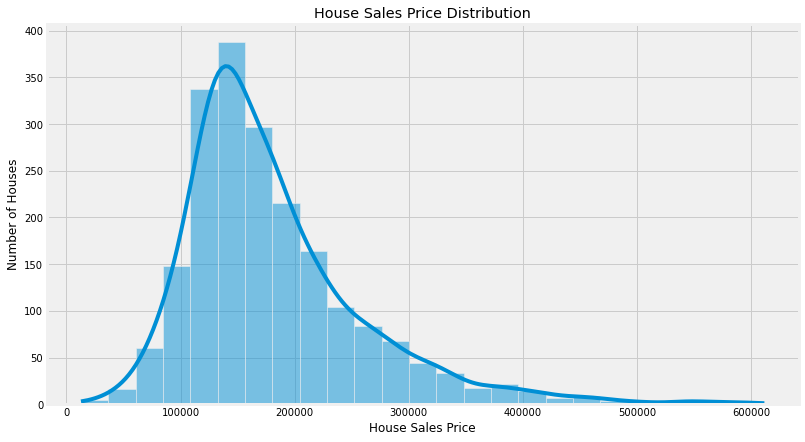

In [173]:
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(df_train['SalePrice'], bins = 25,kde=True)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution");

# Exporting Data

In [144]:
#Divide into test and train:
df_train = df.loc[df['source']=="train"]
df_test = df.loc[df['source']=="test"]#Drop unnecessary columns:
df_test.drop(['SalePrice','source'],axis=1,inplace=True)
df_train.drop(['source'],axis=1,inplace=True)#Export files as modified versions:
df_train.to_csv("../datasets/train_modified.csv",index=False)
df_test.to_csv("../datasets/test_modified.csv",index=False)

C:\Users\olive\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [145]:
df=df_train

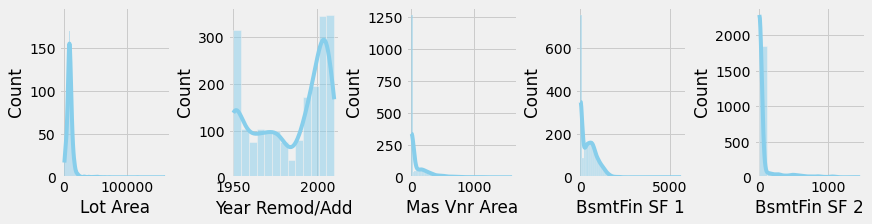

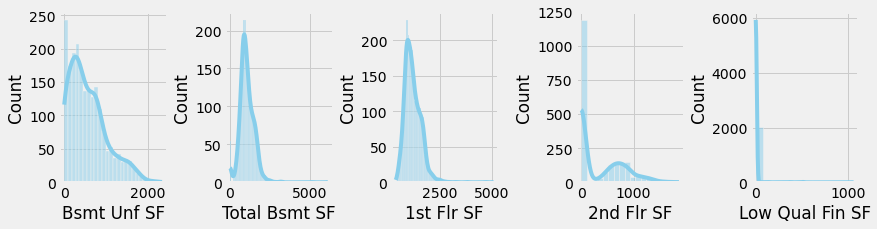

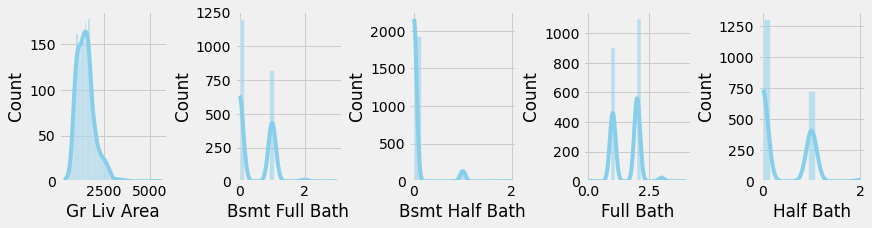

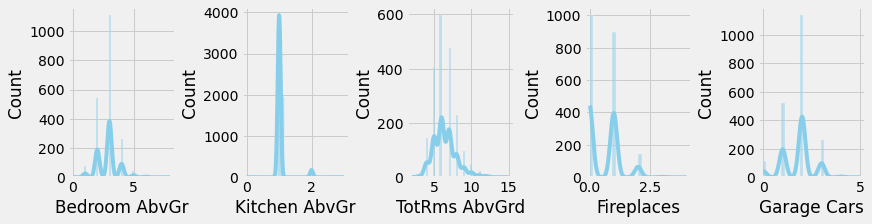

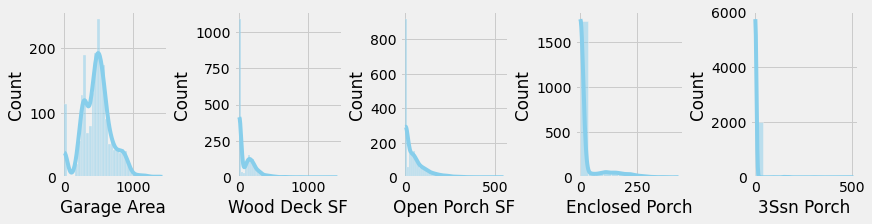

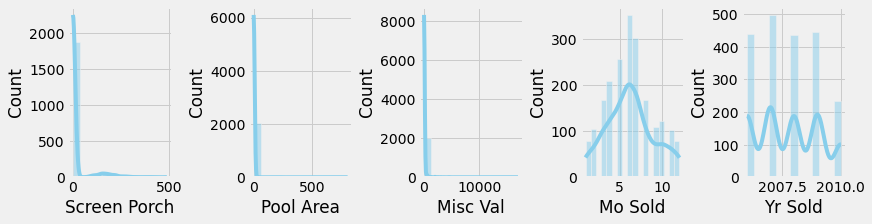

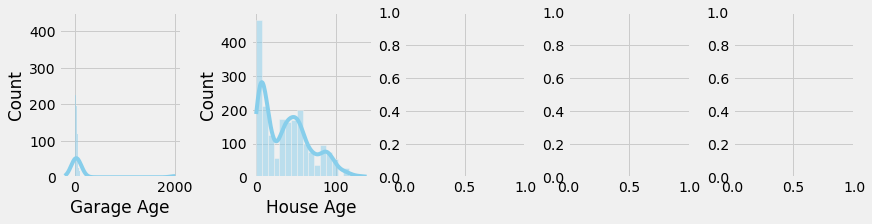

In [146]:

#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
#    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row


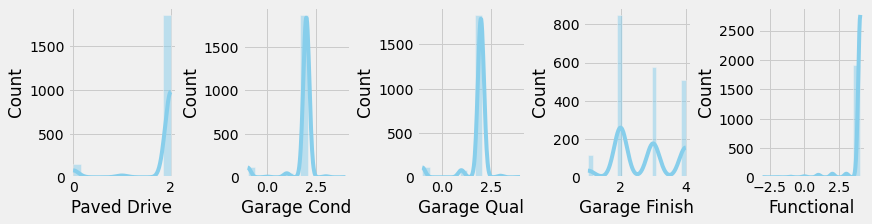

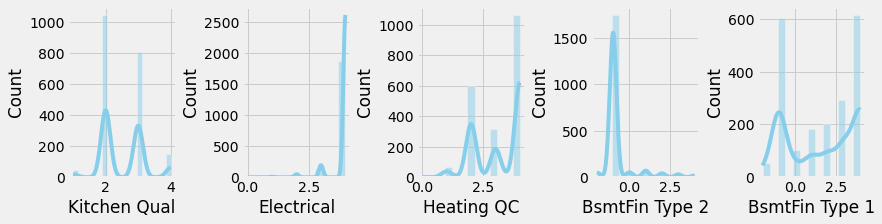

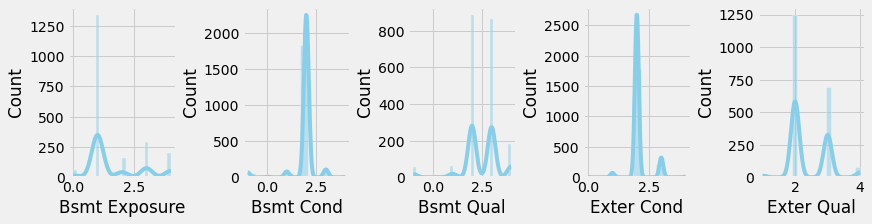

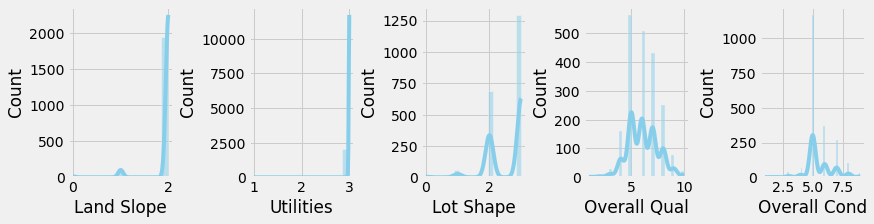

In [147]:

#plot the histogram of each ordinal feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_ordinal)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_ordinal)):
            sns.histplot(data=df, x=features_ordinal[i+j], kde=True, color="skyblue", ax=axs[j])
#    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row

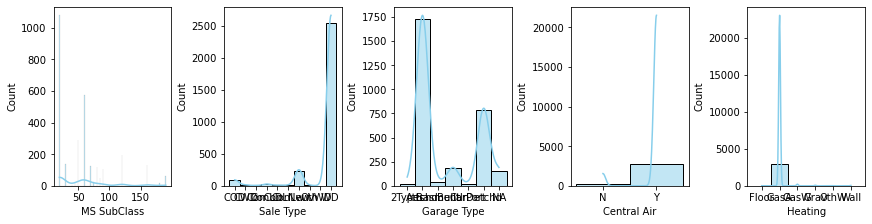

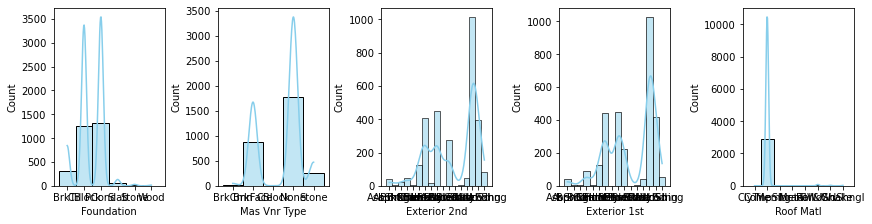

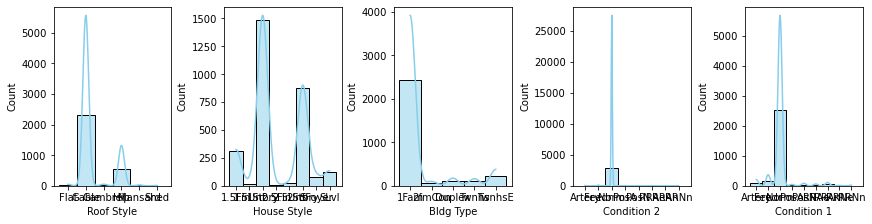

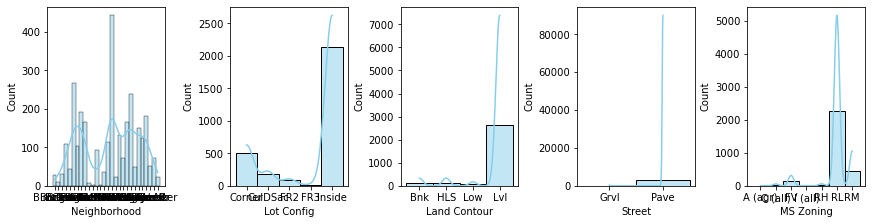

In [78]:

#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_categorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_categorical)):
            sns.histplot(data=df, x=features_categorical[i+j], kde=True, color="skyblue", ax=axs[j])
#    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row

# cleaning and selecting numeric features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

## check and handle outliers of features_numeric[0:5]

In [72]:
df.shape

(2929, 76)

['Lot Area', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2']


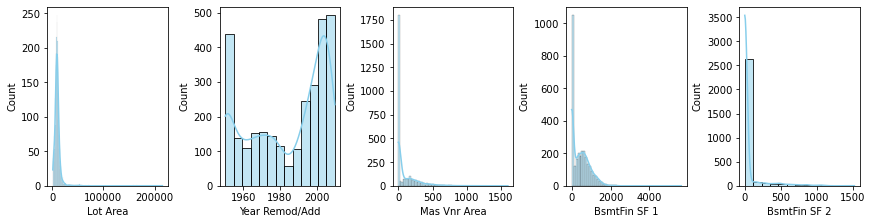

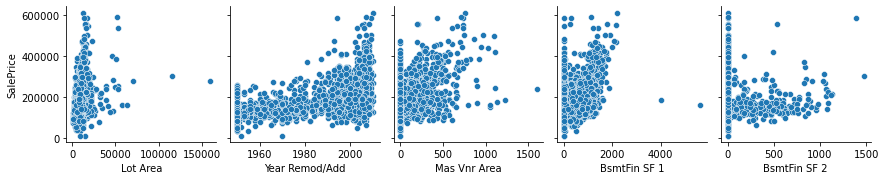

In [79]:
print(features_numeric[:5])
plot_features_numeric(df,features_numeric[:5],"SalePrice")

In [821]:
# features_numeric[0], features_numeric[3], and features_numeric[4] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [0,3,4]
outliers_values = [100_000, 1_500, 3_000]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of Lot Area:  2
deleted outliers of Lot Area
number of outliers of Mas Vnr Area:  1
deleted outliers of Mas Vnr Area
number of outliers of BsmtFin SF 1:  2
deleted outliers of BsmtFin SF 1


(2046, 75)


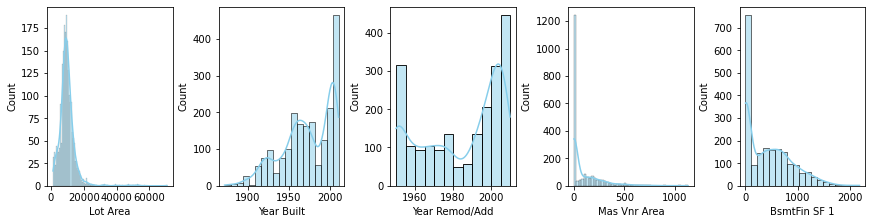

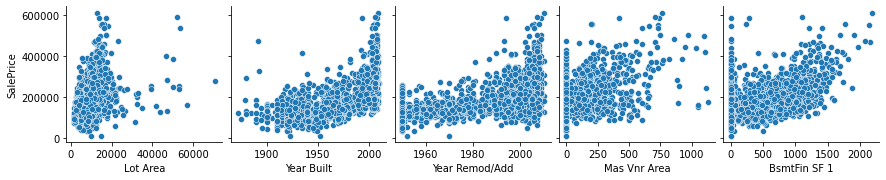

In [822]:
print(df.shape)
plot_features_numeric(df,features_numeric[:5],"SalePrice") 

## check and handle outliers of features_numeric[5:10]

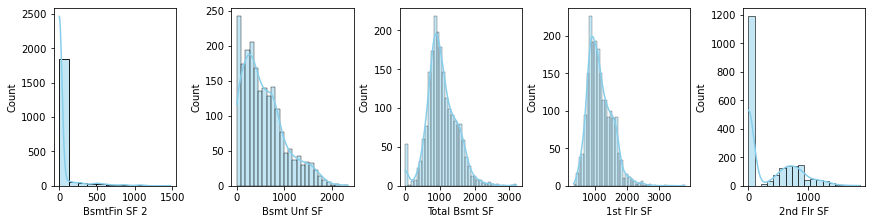

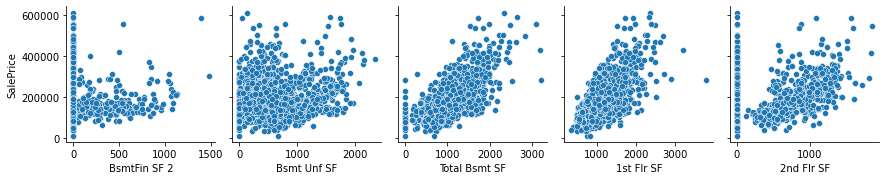

In [823]:
plot_features_numeric(df,features_numeric[5:10],"SalePrice")

In [824]:
# features_numeric[5], features_numeric[7], and features_numeric[8] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [5,7,8]
outliers_values = [1_300, 2_900, 3_000]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of BsmtFin SF 2:  2
deleted outliers of BsmtFin SF 2
number of outliers of Total Bsmt SF:  3
deleted outliers of Total Bsmt SF
number of outliers of 1st Flr SF:  1
deleted outliers of 1st Flr SF


(2040, 75)


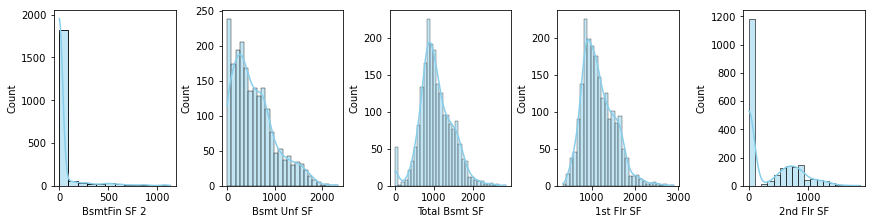

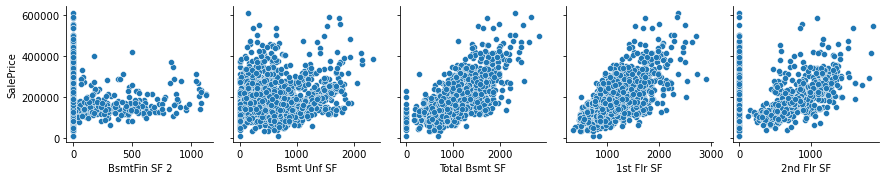

In [825]:
print(df.shape)
plot_features_numeric(df,features_numeric[5:10],"SalePrice") 

## check and handle outliers of features_numeric[10:15]

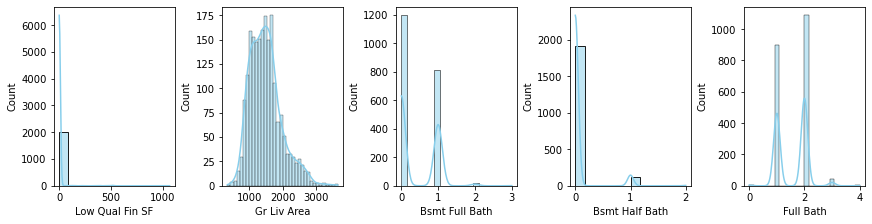

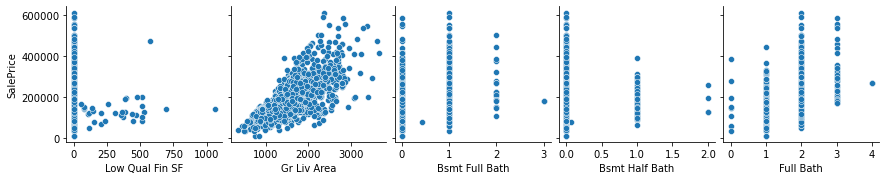

In [826]:
plot_features_numeric(df,features_numeric[10:15],"SalePrice")

In [827]:
# features_numeric[10], features_numeric[12]have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [10]
outliers_values = [570]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")

j = 12
outliers =  df[ (df[features_numeric[j]] > 0) & (df[features_numeric[j]] <1)] 
print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
df.drop(outliers.index, inplace=True)
print(f"deleted outliers of {features_numeric[j]}")


number of outliers of Low Qual Fin SF:  3
deleted outliers of Low Qual Fin SF
number of outliers of Bsmt Full Bath:  1
deleted outliers of Bsmt Full Bath


(2036, 75)


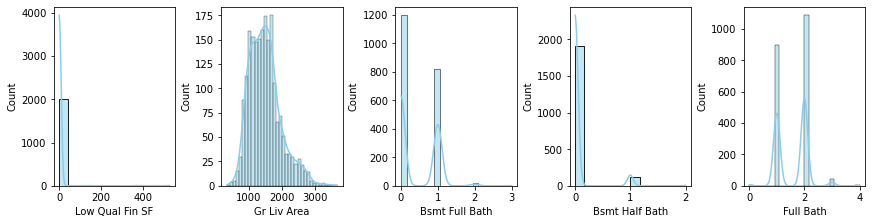

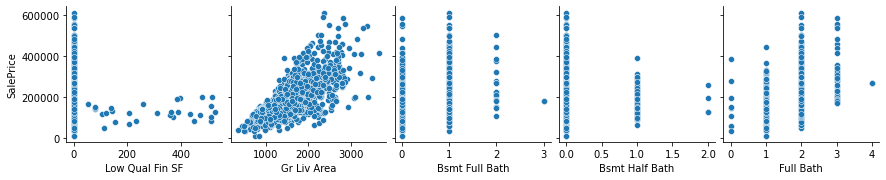

In [828]:
print(df.shape)
plot_features_numeric(df,features_numeric[10:15],"SalePrice") 

## check and handle outliers of features_numeric[15:20]

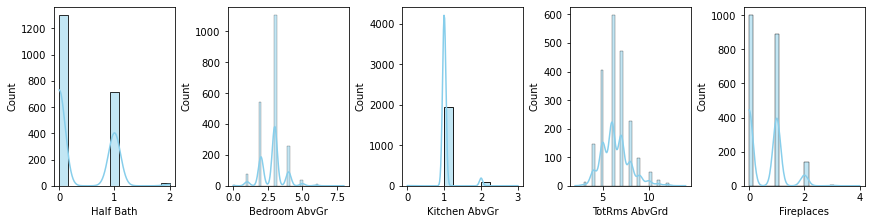

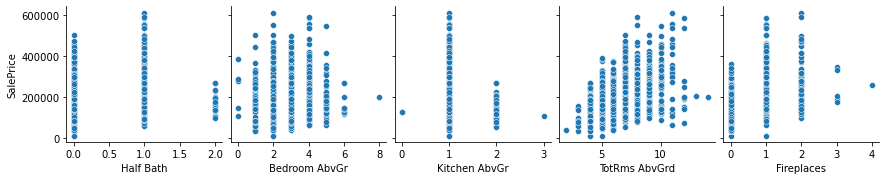

In [829]:
plot_features_numeric(df,features_numeric[15:20],"SalePrice")

In [830]:
print("No outliers found")

No outliers found


## check and handle outliers of features_numeric[20:25]

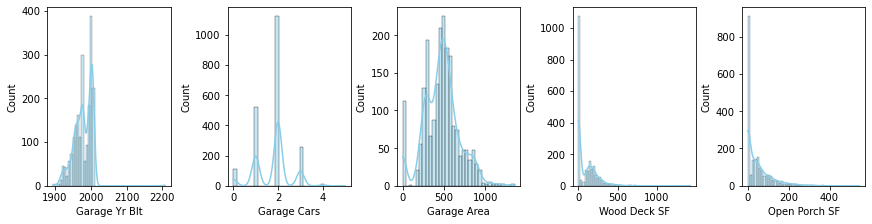

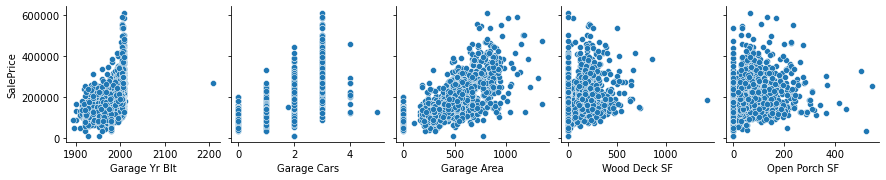

In [831]:
plot_features_numeric(df,features_numeric[20:25],"SalePrice")

In [832]:
# features_numeric[20], features_numeric[23], and features_numeric[24] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [20,23,24]
outliers_values = [2_100, 800, 420]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of Garage Yr Blt:  1
deleted outliers of Garage Yr Blt
number of outliers of Wood Deck SF:  2
deleted outliers of Wood Deck SF
number of outliers of Open Porch SF:  4
deleted outliers of Open Porch SF


(2029, 75)


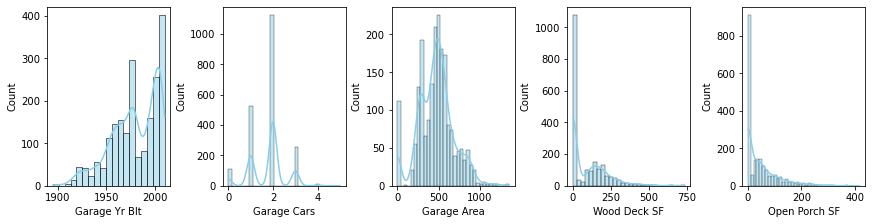

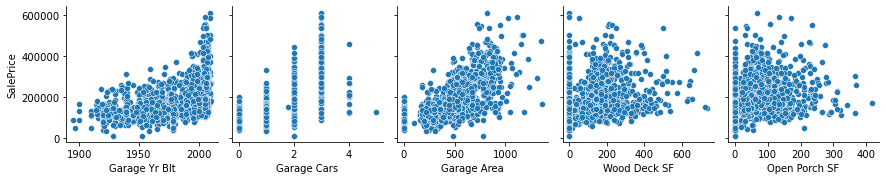

In [833]:
print(df.shape)
plot_features_numeric(df,features_numeric[20:25],"SalePrice") 

## check and handle outliers of features_numeric[25:30]

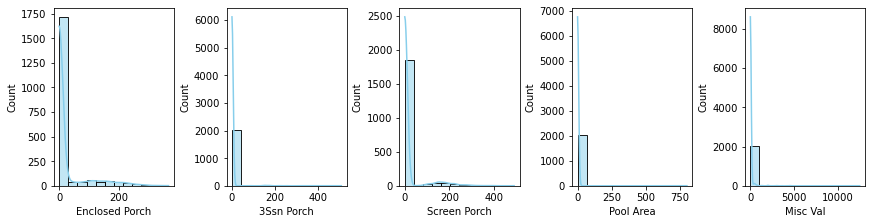

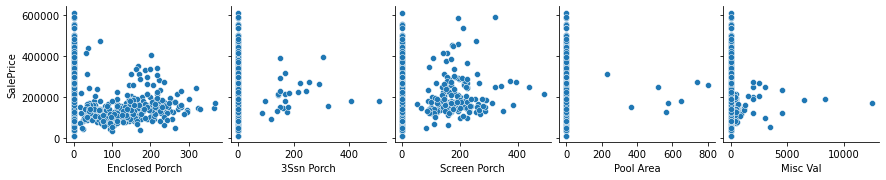

In [834]:
plot_features_numeric(df,features_numeric[25:30],"SalePrice")

In [835]:
# features_numeric[26], features_numeric[29] have outliers, 
# we call the function to replace the outlier 

features_with_outliers = [26,29]
outliers_values = [350, 10_000]

for i in range(len(features_with_outliers)):
    j=features_with_outliers[i]
    outliers =  df[df[features_numeric[j]] > outliers_values[i]]
    print(f"number of outliers of {features_numeric[j]}: ",outliers.shape[0])    
    df.drop(outliers.index, inplace=True)
    print(f"deleted outliers of {features_numeric[j]}")



number of outliers of 3Ssn Porch:  2
deleted outliers of 3Ssn Porch
number of outliers of Misc Val:  1
deleted outliers of Misc Val


(2026, 75)


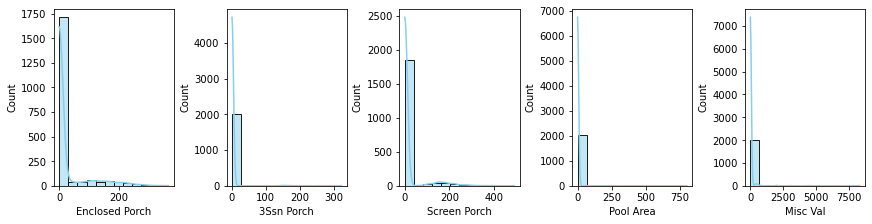

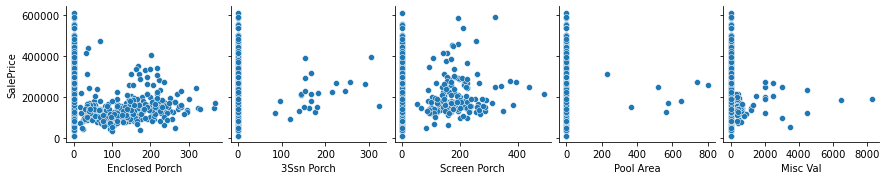

In [836]:
print(df.shape)
plot_features_numeric(df,features_numeric[25:30],"SalePrice") 

In [837]:
print(features_numeric[30:])

['Mo Sold', 'Yr Sold']


## check and handle outliers of features_numeric[30:35]

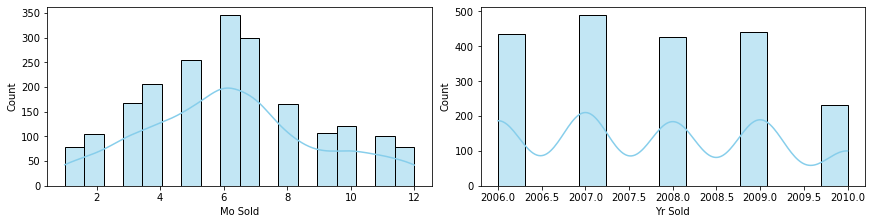

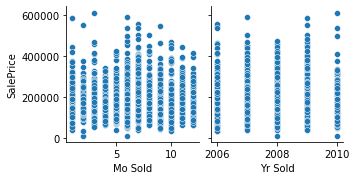

In [838]:
plot_features_numeric(df,features_numeric[30:35],"SalePrice")

In [839]:
print("No outliers found")

No outliers found


In [840]:
df.shape

(2026, 75)

In [841]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row
'''

'\n#plot the histogram of each numeric feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_numeric)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_numeric)):\n            sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])\n    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])\n    i +=columns_in_a_row\n'

In [842]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_numeric)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_numeric)):
            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
            df[features_numeric[i+j]].value_counts(dropna=False).plot(title=features_numeric[i+j], kind='hist',ax=axs[j])
    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])
    i +=columns_in_a_row
'''

'\n#plot the histogram of each numeric feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_numeric)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_numeric)):\n            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])\n            df[features_numeric[i+j]].value_counts(dropna=False).plot(title=features_numeric[i+j], kind=\'hist\',ax=axs[j])\n    sns.pairplot(df, x_vars=features_numeric[i:min(i+columns_in_a_row,len(features_numeric))], y_vars=["saleprice"])\n    i +=columns_in_a_row\n'

In [843]:
'''
#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])
      
    sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
    sns.boxplot(x="ms_subclass", y="saleprice", data=df)
    i +=columns_in_a_row
    
'''

'\n#plot the histogram of each catagorical feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_catagorical)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])\n      \n    sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])\n    sns.boxplot(x="ms_subclass", y="saleprice", data=df)\n    i +=columns_in_a_row\n    \n'

# polynomial

In [844]:
poly = PolynomialFeatures(include_bias=False,interaction_only=False)

df_poly=pd.DataFrame(poly.fit_transform(df[features_numeric]),
                     columns=poly.get_feature_names(features_numeric))
df_poly.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Columns: 560 entries, Lot Area to Yr Sold^2
dtypes: float64(560)
memory usage: 8.7 MB


In [845]:
(df_poly.isnull().sum()/len(df_poly)).sort_values(ascending=False)

Lot Area                          0.0
Bsmt Half Bath Fireplaces         0.0
Bsmt Half Bath^2                  0.0
Bsmt Half Bath Full Bath          0.0
Bsmt Half Bath Half Bath          0.0
Bsmt Half Bath Bedroom AbvGr      0.0
Bsmt Half Bath Kitchen AbvGr      0.0
Bsmt Half Bath TotRms AbvGrd      0.0
Bsmt Half Bath Garage Yr Blt      0.0
Bsmt Full Bath Mo Sold            0.0
Bsmt Half Bath Garage Cars        0.0
Bsmt Half Bath Garage Area        0.0
Bsmt Half Bath Wood Deck SF       0.0
Bsmt Half Bath Open Porch SF      0.0
Bsmt Half Bath Enclosed Porch     0.0
Bsmt Half Bath 3Ssn Porch         0.0
Bsmt Full Bath Yr Sold            0.0
Bsmt Full Bath Misc Val           0.0
Year Built                        0.0
Bsmt Full Bath Garage Yr Blt      0.0
Bsmt Full Bath Full Bath          0.0
Bsmt Full Bath Half Bath          0.0
Bsmt Full Bath Bedroom AbvGr      0.0
Bsmt Full Bath Kitchen AbvGr      0.0
Bsmt Full Bath TotRms AbvGrd      0.0
Bsmt Full Bath Fireplaces         0.0
Bsmt Full Ba

In [846]:
#df2 = pd.concat([df['Id'],df["SalePrice"], df[features_categorical], df[features_ordinal], df_poly], axis=1, join='inner')
#df2 =pd.DataFrame(df[['Id','SalePrice']].join(df[features_categorical], df[features_ordinal], df_poly])
features_to_be_merge = ['Id','SalePrice'] 
df2=pd.merge(df[features_to_be_merge], df_poly,left_index=True, right_index=True)

In [847]:
print(df2.shape)
df2.head(2)

(2001, 562)


Id  SalePrice  Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  \
0  109     130500   13517.0      1976.0          2005.0         289.0   
1  544     220000   11492.0      1996.0          1997.0         132.0   

   BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  \
0         533.0           0.0        192.0          725.0       725.0   
1         637.0           0.0        276.0          913.0       913.0   

   2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  \
0       754.0              0.0       1479.0             0.0             0.0   
1      1209.0              0.0       2122.0             1.0             0.0   

   Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  TotRms AbvGrd  \
0        2.0        1.0            3.0            1.0            6.0   
1        2.0        1.0            4.0            1.0            8.0   

   Fireplaces  Garage Yr Blt  Garage Cars  Garage Area  Wood Deck SF  \
0         0.0         1976.0          2.0        475.0           0.0   
1         1.0         1997.0          2.0        559.0           0.0   

   Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  \
0           44.0             0.0         0.0           0.0        0.0   
1           74.0             0.0         0.0           0.0        0.0   

   Misc Val  Mo Sold  Yr Sold   Lot Area^2  Lot Area Year Built  \
0       0.0      3.0   2010.0  182709289.0           26709592.0   
1       0.0      4.0   2009.0  132066064.0           22938032.0   

   Lot Area Year Remod/Add  Lot Area Mas Vnr Area  Lot Area BsmtFin SF 1  \
0               27101585.0              3906413.0              7204561.0   
1               22949524.0              1516944.0              7320404.0   

   Lot Area BsmtFin SF 2  Lot Area Bsmt Unf SF  Lot Area Total Bsmt SF  \
0                    0.0             2595264.0               9799825.0   
1                    0.0             3171792.0              10492196.0   

   Lot Area 1st Flr SF  Lot Area 2nd Flr SF  Lot Area Low Qual Fin SF  \
0            9799825.0           10191818.0                       0.0   
1           10492196.0           13893828.0                       0.0   

   Lot Area Gr Liv Area  Lot Area Bsmt Full Bath  Lot Area Bsmt Half Bath  \
0            19991643.0                      0.0                      0.0   
1            24386024.0                  11492.0                      0.0   

   Lot Area Full Bath  Lot Area Half Bath  Lot Area Bedroom AbvGr  \
0             27034.0             13517.0                 40551.0   
1             22984.0             11492.0                 45968.0   

   Lot Area Kitchen AbvGr  Lot Area TotRms AbvGrd  Lot Area Fireplaces  \
0                 13517.0                 81102.0                  0.0   
1                 11492.0                 91936.0              11492.0   

   Lot Area Garage Yr Blt  Lot Area Garage Cars  Lot Area Garage Area  \
0              26709592.0               27034.0             6420575.0   
1              22949524.0               22984.0             6424028.0   

   Lot Area Wood Deck SF  Lot Area Open Porch SF  Lot Area Enclosed Porch  \
0                    0.0                594748.0                      0.0   
1                    0.0                850408.0                      0.0   

   Lot Area 3Ssn Porch  Lot Area Screen Porch  Lot Area Pool Area  \
0                  0.0                    0.0                 0.0   
1                  0.0                    0.0                 0.0   

   Lot Area Misc Val  Lot Area Mo Sold  Lot Area Yr Sold  Year Built^2  \
0                0.0           40551.0        27169170.0     3904576.0   
1                0.0           45968.0        23087428.0     3984016.0   

   Year Built Year Remod/Add  Year Built Mas Vnr Area  \
0                  3961880.0                 571064.0   
1                  3986012.0                 263472.0   

   Year Built BsmtFin SF 1  Year Built BsmtFin SF 2  Year Built Bsmt Unf SF  \
0

In [848]:
(df2.isnull().sum()/len(df2)).sort_values(ascending=False)

Id                                0.0
Bsmt Half Bath TotRms AbvGrd      0.0
Bsmt Full Bath Yr Sold            0.0
Bsmt Half Bath^2                  0.0
Bsmt Half Bath Full Bath          0.0
Bsmt Half Bath Half Bath          0.0
Bsmt Half Bath Bedroom AbvGr      0.0
Bsmt Half Bath Kitchen AbvGr      0.0
Bsmt Half Bath Fireplaces         0.0
Bsmt Full Bath Misc Val           0.0
Bsmt Half Bath Garage Yr Blt      0.0
Bsmt Half Bath Garage Cars        0.0
Bsmt Half Bath Garage Area        0.0
Bsmt Half Bath Wood Deck SF       0.0
Bsmt Half Bath Open Porch SF      0.0
Bsmt Half Bath Enclosed Porch     0.0
Bsmt Full Bath Mo Sold            0.0
Bsmt Full Bath Pool Area          0.0
Half Bath Screen Porch            0.0
Bsmt Full Bath Fireplaces         0.0
Bsmt Full Bath Bsmt Half Bath     0.0
Bsmt Full Bath Full Bath          0.0
Bsmt Full Bath Half Bath          0.0
Bsmt Full Bath Bedroom AbvGr      0.0
Bsmt Full Bath Kitchen AbvGr      0.0
Bsmt Full Bath TotRms AbvGrd      0.0
Bsmt Full Ba

## ordinal encode all ordinal features

In [849]:
ordinal_cols_mapping = {
    "Lot Shape": {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    "Utilities": {'AllPub':3, 'NoSewr':2, 'NoSeWa':1,  'ELO':0},
    "Land Slope": {'Gtl':2, 'Mod':1 ,'Sev':0},
    "Exter Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Exter Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Bsmt Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Bsmt Exposure": {'Gd':4, 'Av':3, 'Mn':2 ,'No':1, 'NA':0},
    "BsmtFin Type 1": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "BsmtFin Type 2": {'GLQ':4, 'ALQ':3, 'BLQ':2 ,'Rec':1, 'LwQ':0, 'Unf':-1, 'NA':-2},
    "Heating QC": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Electrical": {'SBrkr':4, 'FuseA':3, 'FuseF':2 ,'FuseP':1, 'Mix':0},
    "Kitchen Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0},
    "Functional": {'Typ':4, 'Min1':3, 'Min2':2 ,'Mod':1, 'Maj1':0, 'Maj2':-1, 'Sev':-2,'Sal':-3},
    "Garage Finish": {'Fin':4, 'RFn':3, 'Unf':2 ,'NA':1},
    "Garage Qual": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Garage Cond": {'Ex':4, 'Gd':3, 'TA':2 ,'Fa':1, 'Po':0, 'NA':-1},
    "Paved Drive": {'Y':2, 'P':1 ,'N':0}
}

 
df3 = df2.join(df[features_ordinal])   
df3 = df3.replace(ordinal_cols_mapping)
print(df3.shape)
df3.head(2)

(2001, 582)


Id  SalePrice  Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  \
0  109     130500   13517.0      1976.0          2005.0         289.0   
1  544     220000   11492.0      1996.0          1997.0         132.0   

   BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  \
0         533.0           0.0        192.0          725.0       725.0   
1         637.0           0.0        276.0          913.0       913.0   

   2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  \
0       754.0              0.0       1479.0             0.0             0.0   
1      1209.0              0.0       2122.0             1.0             0.0   

   Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  TotRms AbvGrd  \
0        2.0        1.0            3.0            1.0            6.0   
1        2.0        1.0            4.0            1.0            8.0   

   Fireplaces  Garage Yr Blt  Garage Cars  Garage Area  Wood Deck SF  \
0         0.0         1976.0          2.0        475.0           0.0   
1         1.0         1997.0          2.0        559.0           0.0   

   Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  \
0           44.0             0.0         0.0           0.0        0.0   
1           74.0             0.0         0.0           0.0        0.0   

   Misc Val  Mo Sold  Yr Sold   Lot Area^2  Lot Area Year Built  \
0       0.0      3.0   2010.0  182709289.0           26709592.0   
1       0.0      4.0   2009.0  132066064.0           22938032.0   

   Lot Area Year Remod/Add  Lot Area Mas Vnr Area  Lot Area BsmtFin SF 1  \
0               27101585.0              3906413.0              7204561.0   
1               22949524.0              1516944.0              7320404.0   

   Lot Area BsmtFin SF 2  Lot Area Bsmt Unf SF  Lot Area Total Bsmt SF  \
0                    0.0             2595264.0               9799825.0   
1                    0.0             3171792.0              10492196.0   

   Lot Area 1st Flr SF  Lot Area 2nd Flr SF  Lot Area Low Qual Fin SF  \
0            9799825.0           10191818.0                       0.0   
1           10492196.0           13893828.0                       0.0   

   Lot Area Gr Liv Area  Lot Area Bsmt Full Bath  Lot Area Bsmt Half Bath  \
0            19991643.0                      0.0                      0.0   
1            24386024.0                  11492.0                      0.0   

   Lot Area Full Bath  Lot Area Half Bath  Lot Area Bedroom AbvGr  \
0             27034.0             13517.0                 40551.0   
1             22984.0             11492.0                 45968.0   

   Lot Area Kitchen AbvGr  Lot Area TotRms AbvGrd  Lot Area Fireplaces  \
0                 13517.0                 81102.0                  0.0   
1                 11492.0                 91936.0              11492.0   

   Lot Area Garage Yr Blt  Lot Area Garage Cars  Lot Area Garage Area  \
0              26709592.0               27034.0             6420575.0   
1              22949524.0               22984.0             6424028.0   

   Lot Area Wood Deck SF  Lot Area Open Porch SF  Lot Area Enclosed Porch  \
0                    0.0                594748.0                      0.0   
1                    0.0                850408.0                      0.0   

   Lot Area 3Ssn Porch  Lot Area Screen Porch  Lot Area Pool Area  \
0                  0.0                    0.0                 0.0   
1                  0.0                    0.0                 0.0   

   Lot Area Misc Val  Lot Area Mo Sold  Lot Area Yr Sold  Year Built^2  \
0                0.0           40551.0        27169170.0     3904576.0   
1                0.0           45968.0        23087428.0     3984016.0   

   Year Built Year Remod/Add  Year Built Mas Vnr Area  \
0                  3961880.0                 571064.0   
1                  3986012.0                 263472.0   

   Year Built BsmtFin SF 1  Year Built BsmtFin SF 2  Year Built Bsmt Unf SF  \
0

# get_dummies

In [786]:
df4 = df3.join(df[features_categorical])
df5 = pd.get_dummies(df4, columns=df4[features_categorical].columns)
print(df5.shape)
df5.head(2)

(2001, 748)


Id  SalePrice  Paved Drive  Garage Cond  Garage Qual  Garage Finish  \
0  109     130500            2            2            2              3   
1  544     220000            2            2            2              3   

   Functional  Kitchen Qual  Electrical  Heating QC  BsmtFin Type 2  \
0           4             3           4           4              -1   
1           4             3           4           4              -1   

   BsmtFin Type 1  Bsmt Exposure  Bsmt Cond  Bsmt Qual  Exter Cond  \
0               4              1          2          2           2   
1               4              1          2          3           2   

   Exter Qual  Land Slope  Utilities  Lot Shape  Overall Qual  Overall Cond  \
0           3           2          3          2             6             8   
1           3           2          3          2             7             5   

   Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  \
0   13517.0      1976.0          2005.0         289.0         533.0   
1   11492.0      1996.0          1997.0         132.0         637.0   

   BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  \
0           0.0        192.0          725.0       725.0       754.0   
1           0.0        276.0          913.0       913.0      1209.0   

   Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
0              0.0       1479.0             0.0             0.0        2.0   
1              0.0       2122.0             1.0             0.0        2.0   

   Half Bath  Bedroom AbvGr  Kitchen AbvGr  TotRms AbvGrd  Fireplaces  \
0        1.0            3.0            1.0            6.0         0.0   
1        1.0            4.0            1.0            8.0         1.0   

   Garage Yr Blt  Garage Cars  Garage Area  Wood Deck SF  Open Porch SF  \
0         1976.0          2.0        475.0           0.0           44.0   
1         1997.0          2.0        559.0           0.0           74.0   

   Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  Misc Val  Mo Sold  \
0             0.0         0.0           0.0        0.0       0.0      3.0   
1             0.0         0.0           0.0        0.0       0.0      4.0   

   Yr Sold   Lot Area^2  Lot Area Year Built  Lot Area Year Remod/Add  \
0   2010.0  182709289.0           26709592.0               27101585.0   
1   2009.0  132066064.0           22938032.0               22949524.0   

   Lot Area Mas Vnr Area  Lot Area BsmtFin SF 1  Lot Area BsmtFin SF 2  \
0              3906413.0              7204561.0                    0.0   
1              1516944.0              7320404.0                    0.0   

   Lot Area Bsmt Unf SF  Lot Area Total Bsmt SF  Lot Area 1st Flr SF  \
0             2595264.0               9799825.0            9799825.0   
1             3171792.0              10492196.0           10492196.0   

   Lot Area 2nd Flr SF  Lot Area Low Qual Fin SF  Lot Area Gr Liv Area  \
0           10191818.0                       0.0            19991643.0   
1           13893828.0                       0.0            24386024.0   

   Lot Area Bsmt Full Bath  Lot Area Bsmt Half Bath  Lot Area Full Bath  \
0                      0.0                      0.0             27034.0   
1                  11492.0                      0.0             22984.0   

   Lot Area Half Bath  Lot Area Bedroom AbvGr  Lot Area Kitchen AbvGr  \
0             13517.0                 40551.0                 13517.0   
1             11492.0                 45968.0                 11492.0   

   Lot Area TotRms AbvGrd  Lot Area Fireplaces  Lot Area Garage Yr Blt  \
0                 81102.0                  0.0              26709592.0   
1                 91936.0              11492.0              22949524.0   

   Lot Area Garage Cars  Lot Area Garage Area  Lot Area Wood Deck SF  \
0               27034.0             6420575.0                    0.0   
1               22984.0             6424028.0                    0.0   

   Lo

In [787]:
(df5.isnull().sum()/len(df5)).sort_values(ascending=False)

Id                                0.0
Fireplaces Mo Sold                0.0
Fireplaces Garage Cars            0.0
Fireplaces Garage Area            0.0
Fireplaces Wood Deck SF           0.0
Fireplaces Open Porch SF          0.0
Fireplaces Enclosed Porch         0.0
Fireplaces 3Ssn Porch             0.0
Fireplaces Screen Porch           0.0
Fireplaces Pool Area              0.0
Fireplaces Misc Val               0.0
Fireplaces Yr Sold                0.0
Garage Yr Blt Mo Sold             0.0
Garage Yr Blt^2                   0.0
Garage Yr Blt Garage Cars         0.0
Garage Yr Blt Garage Area         0.0
Garage Yr Blt Wood Deck SF        0.0
Garage Yr Blt Open Porch SF       0.0
Garage Yr Blt Enclosed Porch      0.0
Garage Yr Blt 3Ssn Porch          0.0
Garage Yr Blt Screen Porch        0.0
Garage Yr Blt Pool Area           0.0
Fireplaces Garage Yr Blt          0.0
Fireplaces^2                      0.0
TotRms AbvGrd Yr Sold             0.0
TotRms AbvGrd Mo Sold             0.0
Kitchen AbvG

## preparing X, Y

In [850]:
X=df2.iloc[:,2:]
features_final = X.columns
X.head(2)

Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  \
0   13517.0      1976.0          2005.0         289.0         533.0   
1   11492.0      1996.0          1997.0         132.0         637.0   

   BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  \
0           0.0        192.0          725.0       725.0       754.0   
1           0.0        276.0          913.0       913.0      1209.0   

   Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
0              0.0       1479.0             0.0             0.0        2.0   
1              0.0       2122.0             1.0             0.0        2.0   

   Half Bath  Bedroom AbvGr  Kitchen AbvGr  TotRms AbvGrd  Fireplaces  \
0        1.0            3.0            1.0            6.0         0.0   
1        1.0            4.0            1.0            8.0         1.0   

   Garage Yr Blt  Garage Cars  Garage Area  Wood Deck SF  Open Porch SF  \
0         1976.0          2.0        475.0           0.0           44.0   
1         1997.0          2.0        559.0           0.0           74.0   

   Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  Misc Val  Mo Sold  \
0             0.0         0.0           0.0        0.0       0.0      3.0   
1             0.0         0.0           0.0        0.0       0.0      4.0   

   Yr Sold   Lot Area^2  Lot Area Year Built  Lot Area Year Remod/Add  \
0   2010.0  182709289.0           26709592.0               27101585.0   
1   2009.0  132066064.0           22938032.0               22949524.0   

   Lot Area Mas Vnr Area  Lot Area BsmtFin SF 1  Lot Area BsmtFin SF 2  \
0              3906413.0              7204561.0                    0.0   
1              1516944.0              7320404.0                    0.0   

   Lot Area Bsmt Unf SF  Lot Area Total Bsmt SF  Lot Area 1st Flr SF  \
0             2595264.0               9799825.0            9799825.0   
1             3171792.0              10492196.0           10492196.0   

   Lot Area 2nd Flr SF  Lot Area Low Qual Fin SF  Lot Area Gr Liv Area  \
0           10191818.0                       0.0            19991643.0   
1           13893828.0                       0.0            24386024.0   

   Lot Area Bsmt Full Bath  Lot Area Bsmt Half Bath  Lot Area Full Bath  \
0                      0.0                      0.0             27034.0   
1                  11492.0                      0.0             22984.0   

   Lot Area Half Bath  Lot Area Bedroom AbvGr  Lot Area Kitchen AbvGr  \
0             13517.0                 40551.0                 13517.0   
1             11492.0                 45968.0                 11492.0   

   Lot Area TotRms AbvGrd  Lot Area Fireplaces  Lot Area Garage Yr Blt  \
0                 81102.0                  0.0              26709592.0   
1                 91936.0              11492.0              22949524.0   

   Lot Area Garage Cars  Lot Area Garage Area  Lot Area Wood Deck SF  \
0               27034.0             6420575.0                    0.0   
1               22984.0             6424028.0                    0.0   

   Lot Area Open Porch SF  Lot Area Enclosed Porch  Lot Area 3Ssn Porch  \
0                594748.0                      0.0                  0.0   
1                850408.0                      0.0                  0.0   

   Lot Area Screen Porch  Lot Area Pool Area  Lot Area Misc Val  \
0                    0.0                 0.0                0.0   
1                    0.0                 0.0                0.0   

   Lot Area Mo Sold  Lot Area Yr Sold  Year Built^2  \
0           40551.0        27169170.0     3904576.0   
1           45968.0        23087428.0     3984016.0   

   Year Built Year Remod/Add  Year Built Mas Vnr Area  \
0                  3961880.0                 571064.0   
1                  3986012.0                 263472.0   

   Year Built BsmtFin SF 1  Year Built BsmtFin SF 2  Year Built Bsmt Unf SF  \
0                1053208.0                      

In [851]:
df3['SalePrice_per_sf'] = df3['SalePrice'] / df3['Gr Liv Area']
#y = df3['SalePrice_per_sf']
y = df2['SalePrice']

## feature selection

In [853]:
features_final=forward_selection(X,y)

C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: Th

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

In [854]:
print(features_final)

['Gr Liv Area Garage Area', 'Low Qual Fin SF Misc Val', 'Yr Sold', 'Half Bath Pool Area', 'Enclosed Porch Pool Area', '2nd Flr SF Screen Porch', 'Half Bath Screen Porch', 'Bedroom AbvGr Garage Area', '2nd Flr SF Enclosed Porch', 'Mas Vnr Area BsmtFin SF 2', 'BsmtFin SF 2 Open Porch SF']


# try to use Lasso to get rid of some features


In [858]:
%%time
X=X[features_final]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
#alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
#alphas = [x for x in range(1000)]
alphas = np.logspace(0, 5, 100)
best_alpha= None
best_gs = None

for i in range(20):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[("scaler",  MinMaxScaler()), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha


best performing model: {'classifier': Lasso(), 'classifier__alpha': 1.0}
Mse score:  5864899331.3159685
mse of train data:  5666826137.664714
mse of test data:  5720645236.697763
diff%:  -0.9497220794430146%
lkdijf
best performing model: {'classifier': Lasso(alpha=0.8), 'classifier__alpha': 0.8}
Mse score:  5864899000.1945715
mse of train data:  5666826137.453461
mse of test data:  5720644993.171117
diff%:  -0.9497177857981907%
lkdijf
best performing model: {'classifier': Lasso(alpha=0.64), 'classifier__alpha': 0.64}
Mse score:  5864898735.332345
mse of train data:  5666826137.318257
mse of test data:  5720644798.38491
diff%:  -0.9497143508997999%
lkdijf
best performing model: {'classifier': Lasso(alpha=0.512), 'classifier__alpha': 0.512}
Mse score:  5864898523.464877
mse of train data:  5666826137.231727
mse of test data:  5720644642.578473
diff%:  -0.9497116029932948%
lkdijf
best performing model: {'classifier': Lasso(alpha=0.4096), 'classifier__alpha': 0.4096}
Mse score:  5864898353

In [859]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

best performing model: {'classifier': Lasso(alpha=0.014411518807585582), 'classifier__alpha': 0.014411518807585582}
mse of train data:  5666826137.078018
mse of test data:  5720644037.084908
diff%:  -0.9497009208516044%


feature         coef     abs_coef
0                      Yr Sold -4061.879017  4061.879017
1          Half Bath Pool Area   451.612573   451.612573
2       Half Bath Screen Porch   110.267085   110.267085
3    Bedroom AbvGr Garage Area   -11.127692    11.127692
4     Enclosed Porch Pool Area    -6.290504     6.290504
5     Low Qual Fin SF Misc Val     1.526277     1.526277
6   BsmtFin SF 2 Open Porch SF     0.345089     0.345089
7      2nd Flr SF Screen Porch    -0.216126     0.216126
8    Mas Vnr Area BsmtFin SF 2    -0.189583     0.189583
9    2nd Flr SF Enclosed Porch     0.111666     0.111666
10     Gr Liv Area Garage Area     0.035313     0.035313

## LassoCV

In [715]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(0, 5, 1000)
# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=1000)
# Fit model using best ridge alpha!
lasso_cv.fit(X_train, y_train);

# Here is the optimal value of alpha
print(lasso_cv.alpha_)



1.0


In [716]:
coefs = lasso_cv.coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

feature          coef      abs_coef
0        Half Bath Kitchen AbvGr -1.977465e+01  1.977465e+01
1                   Overall Qual  1.812240e+01  1.812240e+01
2           Neighborhood_NridgHt  1.544706e+01  1.544706e+01
3                      Bsmt Qual  1.209696e+01  1.209696e+01
4                 Bldg Type_1Fam  1.152908e+01  1.152908e+01
5                   Kitchen Qual  1.015259e+01  1.015259e+01
6                     Exter Qual  5.246673e+00  5.246673e+00
7                  Garage Finish  4.196709e+00  4.196709e+00
8                  Bsmt Exposure  3.582461e+00  3.582461e+00
9                    Full Bath^2  2.965618e+00  2.965618e+00
10                BsmtFin Type 1  2.301498e+00  2.301498e+00
11             Mas Vnr Type_None -1.031929e+00  1.031929e+00
12          Neighborhood_Crawfor  2.029406e-01  2.029406e-01
13           Half Bath Pool Area  1.934593e-01  1.934593e-01
14        Full Bath Screen Porch -3.913928e-02  3.913928e-02
15             Pool Area Mo Sold -2.398347e-02  2.398347e-02
16          Year Built Full Bath -2.239187e-02  2.239187e-02
17   Total Bsmt SF Kitchen AbvGr -1.234984e-02  1.234984e-02
18      Low Qual Fin SF Misc Val  7.991936e-04  7.991936e-04
19     2nd Flr SF Enclosed Porch -1.640951e-04  1.640951e-04
20     Mas Vnr Area BsmtFin SF 2 -7.657318e-05  7.657318e-05
21  Year Remod/Add Garage Yr Blt -2.901910e-05  2.901910e-05
22     Mas Vnr Area BsmtFin SF 1 -1.852609e-05  1.852609e-05
23          Lot Area Bsmt Unf SF -7.462969e-07  7.462969e-07
24                MS SubClass_90  0.000000e+00  0.000000e+00
25                   Garage Qual  0.000000e+00  0.000000e+00
26          Neighborhood_NPkVill -0.000000e+00  0.000000e+00
27          Neighborhood_Blmngtn -0.000000e+00  0.000000e+00
28                  MS Zoning_RH -0.000000e+00  0.000000e+00
29          Neighborhood_StoneBr  0.000000e+00  0.000000e+00
30          Exterior 1st_Plywood  0.000000e+00  0.000000e+00
31          Neighborhood_Somerst -0.000000e+00  0.000000e+00
32              Bldg Type_Duplex  0.000000e+00  0.000000e+00
33            House Style_SFoyer -0.000000e+00  0.000000e+00
34                 Central Air_Y  0.000000e+00  0.000000e+00
35                 Central Air_N -0.000000e+00  0.000000e+00
36                     Full Bath -0.000000e+00  0.000000e+00
37          Exterior 1st_BrkFace  0.000000e+00  0.000000e+00
38          Neighborhood_NoRidge  0.000000e+00  0.000000e+00
39          Exterior 1st_CemntBd  0.000000e+00  0.000000e+00
40              Bldg Type_2fmCon  0.000000e+00  0.000000e+00
41              Condition 1_PosA  0.000000e+00  0.000000e+00

In [720]:
features_final2 = df_coefs.loc[df_coefs["abs_coef"]>1,'feature'].to_list()
print(features_final2)

['Half Bath Kitchen AbvGr', 'Overall Qual', 'Neighborhood_NridgHt', 'Bsmt Qual', 'Bldg Type_1Fam', 'Kitchen Qual', 'Exter Qual', 'Garage Finish', 'Bsmt Exposure', 'Full Bath^2', 'BsmtFin Type 1', 'Mas Vnr Type_None']


In [723]:
%%time
X=df4[features_final2]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
#alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
#alphas = [x for x in range(1000)]
alphas = np.logspace(0, 5, 100)
best_alpha= None
best_gs = None

for i in range(20):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[("scaler",  MinMaxScaler()), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha


best performing model: {'classifier': Lasso(), 'classifier__alpha': 1.0}
Mse score:  2005.8624959077406
mse of train data:  1935.5204991286143
mse of test data:  2102.1277142123677
diff%:  -8.607876545805695%
lkdijf
best performing model: {'classifier': Lasso(alpha=0.8), 'classifier__alpha': 0.8}
Mse score:  1992.0894425766394
mse of train data:  1923.4987577492093
mse of test data:  2091.495802415268
diff%:  -8.733930499785773%
best performing model: {'classifier': Lasso(alpha=0.64), 'classifier__alpha': 0.64}
Mse score:  1983.1814021985003
mse of train data:  1915.804906889551
mse of test data:  2084.7412580007026
diff%:  -8.818035203043308%
best performing model: {'classifier': Lasso(alpha=0.512), 'classifier__alpha': 0.512}
Mse score:  1977.4037836390835
mse of train data:  1910.8804445242683
mse of test data:  2080.459764597242
diff%:  -8.874407635439075%
best performing model: {'classifier': Lasso(alpha=0.4096), 'classifier__alpha': 0.4096}
Mse score:  1973.647264056417
mse of tr

In [724]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

best performing model: {'classifier': Lasso(), 'classifier__alpha': 1.0}
mse of train data:  1902.1345541361113
mse of test data:  2073.273091193136
diff%:  -8.997183542294175%


feature       coef   abs_coef
0                  Overall Qual -20.124958  20.124958
1                     Full Bath  16.818739  16.818739
2       Half Bath Kitchen AbvGr  15.962112  15.962112
3                MS SubClass_90 -13.099455  13.099455
4                     Bsmt Qual  11.375828  11.375828
5   Total Bsmt SF Kitchen AbvGr   9.893979   9.893979
6                  Kitchen Qual   9.543568   9.543568
7          Neighborhood_NridgHt   7.859878   7.859878
8                Bldg Type_1Fam   4.602671   4.602671
9                BsmtFin Type 1   3.932811   3.932811
10    2nd Flr SF Enclosed Porch  -2.480421   2.480421
11             Bldg Type_Duplex   2.280378   2.280378

In [354]:

df_poly.head()

Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  \
0   13517.0      1976.0          2005.0         289.0         533.0   
1   11492.0      1996.0          1997.0         132.0         637.0   
2    7922.0      1953.0          2007.0           0.0         731.0   
3    9802.0      2006.0          2007.0           0.0           0.0   
4   14235.0      1900.0          1993.0           0.0           0.0   

   BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  \
0           0.0        192.0          725.0       725.0       754.0   
1           0.0        276.0          913.0       913.0      1209.0   
2           0.0        326.0         1057.0      1057.0         0.0   
3           0.0        384.0          384.0       744.0       700.0   
4           0.0        676.0          676.0       831.0       614.0   

   Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
0              0.0       1479.0             0.0             0.0        2.0   
1              0.0       2122.0             1.0             0.0        2.0   
2              0.0       1057.0             1.0             0.0        1.0   
3              0.0       1444.0             0.0             0.0        2.0   
4              0.0       1445.0             0.0             0.0        2.0   

   Half Bath  Bedroom AbvGr  Kitchen AbvGr  TotRms AbvGrd  Fireplaces  \
0        1.0            3.0            1.0            6.0         0.0   
1        1.0            4.0            1.0            8.0         1.0   
2        0.0            3.0            1.0            5.0         0.0   
3        1.0            3.0            1.0            7.0         0.0   
4        0.0            3.0            1.0            6.0         0.0   

   Garage Yr Blt  Garage Cars  Garage Area  Wood Deck SF  Open Porch SF  \
0         1976.0          2.0        475.0           0.0           44.0   
1         1997.0          2.0        559.0           0.0           74.0   
2         1953.0          1.0        246.0           0.0           52.0   
3         2007.0          2.0        400.0         100.0            0.0   
4         1957.0          2.0        484.0           0.0           59.0   

   Enclosed Porch  3Ssn Porch  Screen Porch  Pool Area  Misc Val  Mo Sold  \
0             0.0         0.0           0.0        0.0       0.0      3.0   
1             0.0         0.0           0.0        0.0       0.0      4.0   
2             0.0         0.0           0.0        0.0       0.0      1.0   
3             0.0         0.0           0.0        0.0       0.0      4.0   
4             0.0         0.0           0.0        0.0       0.0      3.0   

   Yr Sold   Lot Area^2  Lot Area Year Built  Lot Area Year Remod/Add  \
0   2010.0  182709289.0           26709592.0               27101585.0   
1   2009.0  132066064.0           22938032.0               22949524.0   
2   2010.0   62758084.0           15471666.0               15899454.0   
3   2010.0   96079204.0           19662812.0               19672614.0   
4   2010.0  202635225.0           27046500.0               28370355.0   

   Lot Area Mas Vnr Area  Lot Area BsmtFin SF 1  Lot Area BsmtFin SF 2  \
0              3906413.0              7204561.0                    0.0   
1              1516944.0              7320404.0                    0.0   
2                    0.0              5790982.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   Lot Area Bsmt Unf SF  Lot Area Total Bsmt SF  Lot Area 1st Flr SF  \
0             2595264.0               9799825.0            9799825.0   
1             3171792.0              10492196.0           10492196.0   
2             2582572.0               8373554.0            8373554.0   
3             3763968.0               3763968.0            7292688.0   
4             9622860.0               9622860.0           11829285.0   

   Lot Are

In [615]:
sr_corr = df_poly.corr()['SalePrice'].sort_values(ascending=False)

In [616]:
df_corr = pd.DataFrame({"feature":sr_corr.index, "corr":sr_corr})

In [618]:
df_corr.reset_index(drop=True,inplace=True)

In [623]:
df_corr_filtered= df_corr[~df_corr['feature'].str.contains("SalePrice")]

In [624]:
df_corr_filtered.head(100)

feature      corr
16       Overall Qual Gr Liv Area  0.837152
17                 Overall Qual^2  0.825539
19       Overall Qual Garage Cars  0.820249
20       Overall Qual Garage Area  0.813508
21        Overall Qual Year Built  0.806902
22     Overall Qual Garage Yr Blt  0.805173
23    Overall Qual Year Remod/Add  0.804740
24                   Overall Qual  0.800207
25           Overall Qual Yr Sold  0.800185
26     Overall Qual TotRms AbvGrd  0.795420
27        Gr Liv Area Garage Cars  0.793384
28        Overall Qual 1st Flr SF  0.792151
29     Overall Qual Total Bsmt SF  0.768417
30      Total Bsmt SF Garage Cars  0.767288
31         1st Flr SF Garage Cars  0.760306
32         Overall Qual Full Bath  0.756694
33        Gr Liv Area Garage Area  0.754707
35          Full Bath Garage Area  0.738155
36      TotRms AbvGrd Garage Cars  0.720261
37      TotRms AbvGrd Garage Area  0.719520
38         Year Built Gr Liv Area  0.716450
39          Full Bath Garage Cars  0.714838
40        Total Bsmt SF Full Bath  0.712136
41      Gr Liv Area Garage Yr Blt  0.710009
42     Year Remod/Add Gr Liv Area  0.707879
43         1st Flr SF Garage Area  0.705465
44                    Gr Liv Area  0.697038
45            Gr Liv Area Yr Sold  0.697030
46      Total Bsmt SF Garage Area  0.692227
47        Garage Cars Garage Area  0.690676
48           1st Flr SF Full Bath  0.686567
50          Gr Liv Area Full Bath  0.682967
53                  Garage Cars^2  0.664601
54         Year Built Garage Area  0.661839
55         Year Built Garage Cars  0.659112
56     Year Remod/Add Garage Area  0.658540
57      Garage Yr Blt Garage Area  0.657657
58     Year Remod/Add Garage Cars  0.656465
59      Garage Yr Blt Garage Cars  0.655939
60    Total Bsmt SF TotRms AbvGrd  0.650493
61                    Garage Area  0.650246
62            Garage Area Yr Sold  0.650234
63                    Garage Cars  0.648197
64            Garage Cars Yr Sold  0.648188
65                  Garage Area^2  0.642790
66       Year Built Total Bsmt SF  0.639968
67    Total Bsmt SF Garage Yr Blt  0.638037
68   Year Remod/Add Total Bsmt SF  0.637991
70         Fireplaces Garage Cars  0.634926
71          Year Built 1st Flr SF  0.634583
72       1st Flr SF Garage Yr Blt  0.631760
73      Year Remod/Add 1st Flr SF  0.630917
74         Fireplaces Garage Area  0.630767
75                  Gr Liv Area^2  0.629686
76         1st Flr SF Gr Liv Area  0.629107
77                  Total Bsmt SF  0.628668
78          Total Bsmt SF Yr Sold  0.628657
79       1st Flr SF TotRms AbvGrd  0.626405
80      Total Bsmt SF Gr Liv Area  0.624640
81      Year Built Year Remod/Add  0.622283
82     Overall Qual Kitchen AbvGr  0.621897
83                     1st Flr SF  0.618486
84             1st Flr SF Yr Sold  0.618476
85      Gr Liv Area TotRms AbvGrd  0.615463
86        Overall Qual Fireplaces  0.606518
87       Mas Vnr Area Garage Cars  0.605663
88        Full Bath TotRms AbvGrd  0.601315
90       Mas Vnr Area Garage Area  0.590052
92   Year Remod/Add Garage Yr Blt  0.587020
93     Overall Qual Bedroom AbvGr  0.583210
94       Year Built Garage Yr Blt  0.581636
95      Overall Qual Mas Vnr Area  0.581556
96           Full Bath Fireplaces  0.576861
97      Bedroom AbvGr Garage Area  0.575512
98       Overall Cond Garage Cars  0.574362
99                   Year Built^2  0.574040
100        Gr Liv Area Fireplaces  0.572393
101                    Year Built  0.571849
102        Mas Vnr Area Full Bath  0.571568
103            Year Built Yr Sold  0.570780
104      Overall Cond Garage Area  0.569491
105     Bedroom AbvGr Garage Cars  0.566903
106    Overall Cond Total Bsmt SF  0.565606
107     Overall Qual Overall Cond  0.565244
108      BsmtFin SF 1 Garage Cars  0.563973
110      Overall Cond Gr Liv Area  0.561882
112      Total Bsmt SF Fireplaces  0.557529
114          Year Built Full Bath  0.552592
115              Year Remod/Add^2  0.550681
116                Year Remod/Add  0.550370
117    Mas Vnr Area To

In [273]:
print(features_categorical)

['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Neighborhood', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']


In [324]:
#features_final = features_ordinal + features_categorical + features_numeric
features_categorical_selected = ['Condition 2', 'Condition 1', 'Neighborhood','Garage Type','Roof Matl', 'Roof Style']
features_final = features_ordinal + features_numeric + features_categorical
print(features_final)


X = df[features_final]
X = pd.get_dummies(X, columns=X[features_categorical].columns)



df['SalePrice_per_sf'] = df['SalePrice'] / df['Gr Liv Area']
y = df['SalePrice_per_sf']
#y = df['SalePrice']

X.head()

['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope', 'Utilities', 'Lot Shape', 'Overall Qual', 'Overall Cond', 'Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 

Paved Drive  Garage Cond  Garage Qual  Garage Finish  Functional  \
0            2            2            2              3           4   
1            2            2            2              3           4   
2            2            2            2              2           4   
3            2            2            2              4           4   
4            0            2            2              2           4   

   Kitchen Qual  Electrical  Heating QC  BsmtFin Type 2  BsmtFin Type 1  \
0             3           4           4              -1               4   
1             3           4           4              -1               4   
2             3           4           2              -1               4   
3             2           4           3              -1              -1   
4             2           4           2              -1              -1   

   Bsmt Exposure  Bsmt Cond  Bsmt Qual  Exter Cond  Exter Qual  Land Slope  \
0              1          2          2           2           3           2   
1              1          2          3           2           3           2   
2              1          2          2           3           2           2   
3              1          2          3           2           2           2   
4              1          3          1           2           2           2   

   Utilities  Lot Shape  Overall Qual  Overall Cond  Lot Area  Year Built  \
0          3          2             6             8     13517        1976   
1          3          2             7             5     11492        1996   
2          3          3             5             7      7922        1953   
3          3          3             5             5      9802        2006   
4          3          2             6             8     14235        1900   

   Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  \
0            2005         289.0         533.0           0.0        192.0   
1            1997         132.0         637.0           0.0        276.0   
2            2007           0.0         731.0           0.0        326.0   
3            2007           0.0           0.0           0.0        384.0   
4            1993           0.0           0.0           0.0        676.0   

   Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   
2         1057.0        1057           0                0         1057   
3          384.0         744         700                0         1444   
4          676.0         831         614                0         1445   

   Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2          1              3   
4             0.0             0.0          2          0              3   

   Kitchen AbvGr  TotRms AbvGrd  Fireplaces  Garage Yr Blt  Garage Cars  \
0              1              6           0         1976.0          2.0   
1              1              8           1         1997.0          2.0   
2              1              5           0         1953.0          1.0   
3              1              7           0         2007.0          2.0   
4              1              6           0         1957.0          2.0   

   Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
0        475.0             0             44               0           0   
1        559.0             0             74               0           0   
2        246.0             0             52               0           0   
3        400.0           100              0               0           0   
4        484.0      

In [325]:
features_final2=forward_selection(X,y)

C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: Th

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\AppData\Local\Temp/ipykernel_4748/1482045589.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\olive\anaconda3\lib\site-p

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarnin

In [326]:
print(features_final2)

['Year Built', '2nd Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Gr Liv Area', 'Overall Cond', 'Lot Area', 'Exter Qual', 'Sale Type_New', 'Bsmt Qual', 'Garage Area', 'Functional', 'MS SubClass_160', 'Total Bsmt SF', 'Land Contour_HLS', 'Neighborhood_NridgHt', 'Neighborhood_GrnHill', 'Kitchen Qual', 'Neighborhood_StoneBr', 'Fireplaces', 'MS SubClass_20', 'Bsmt Exposure', 'Neighborhood_Somerst', 'Neighborhood_NoRidge', 'Exterior 1st_BrkFace', 'Condition 1_Artery', 'Neighborhood_Crawfor', 'MS SubClass_30', 'MS SubClass_60', 'Screen Porch', 'Heating QC', 'MS SubClass_85', 'Wood Deck SF', 'MS SubClass_45', 'Mas Vnr Area', 'Garage Cond', 'MS Zoning_C (all)', 'Bsmt Full Bath', 'Sale Type_COD', 'House Style_2.5Fin', 'Sale Type_Con', 'Neighborhood_Edwards', 'Condition 1_Norm', 'Condition 1_PosN', 'Condition 1_PosA', 'Mas Vnr Type_BrkFace', 'Roof Style_Mansard', 'MS SubClass_150', 'MS Zoning_RM', 'Heating_Grav', 'Year Remod/Add', 'Neighborhood_ClearCr', 'Exterior 2nd_MetalSd', 'Neighborhood_NPkVill

In [532]:
df1 = pd.get_dummies(df, columns=df[features_categorical].columns)


In [533]:
df1.corr()['SalePrice'].sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.800207
Exter Qual              0.712146
Gr Liv Area             0.697038
Kitchen Qual            0.692336
Bsmt Qual               0.682238
Garage Area             0.650246
Garage Cars             0.648197
SalePrice_per_sf        0.631411
Total Bsmt SF           0.628668
1st Flr SF              0.618486
Year Built              0.571849
Year Remod/Add          0.550370
Garage Finish           0.548420
Full Bath               0.537969
Foundation_PConc        0.529047
Garage Yr Blt           0.516738
Mas Vnr Area            0.508602
TotRms AbvGrd           0.504014
Fireplaces              0.471093
Heating QC              0.458354
Neighborhood_NridgHt    0.448647
BsmtFin SF 1            0.423346
Bsmt Exposure           0.413408
Sale Type_New           0.358102
MS SubClass_60          0.355421
Exterior 1st_VinylSd    0.342146
Exterior 2nd_VinylSd    0.337563
Open Porch SF           0.333476
Wood Deck SF            0.326490
Mas Vnr Ty

In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 76 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                2051 non-null   object  
 1   PID               2051 non-null   object  
 2   MS SubClass       2051 non-null   category
 3   MS Zoning         2051 non-null   category
 4   Lot Area          2051 non-null   int64   
 5   Street            2051 non-null   category
 6   Lot Shape         2051 non-null   int64   
 7   Land Contour      2051 non-null   category
 8   Utilities         2051 non-null   int64   
 9   Lot Config        2051 non-null   category
 10  Land Slope        2051 non-null   int64   
 11  Neighborhood      2051 non-null   category
 12  Condition 1       2051 non-null   category
 13  Condition 2       2051 non-null   category
 14  Bldg Type         2051 non-null   category
 15  House Style       2051 non-null   category
 16  Overall Qual      2051 n

In [363]:
X.head()

Paved Drive  Garage Cond  Garage Qual  Garage Finish  Functional  \
0            2            2            2              3           4   
1            2            2            2              3           4   
2            2            2            2              2           4   
3            2            2            2              4           4   
4            0            2            2              2           4   

   Kitchen Qual  Electrical  Heating QC  BsmtFin Type 2  BsmtFin Type 1  \
0             3           4           4              -1               4   
1             3           4           4              -1               4   
2             3           4           2              -1               4   
3             2           4           3              -1              -1   
4             2           4           2              -1              -1   

   Bsmt Exposure  Bsmt Cond  Bsmt Qual  Exter Cond  Exter Qual  Land Slope  \
0              1          2          2           2           3           2   
1              1          2          3           2           3           2   
2              1          2          2           3           2           2   
3              1          2          3           2           2           2   
4              1          3          1           2           2           2   

   Utilities  Lot Shape  Lot Area  Overall Qual  Overall Cond  Year Built  \
0          3          2     13517             6             8        1976   
1          3          2     11492             7             5        1996   
2          3          3      7922             5             7        1953   
3          3          3      9802             5             5        2006   
4          3          2     14235             6             8        1900   

   Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  \
0            2005         289.0         533.0           0.0        192.0   
1            1997         132.0         637.0           0.0        276.0   
2            2007           0.0         731.0           0.0        326.0   
3            2007           0.0           0.0           0.0        384.0   
4            1993           0.0           0.0           0.0        676.0   

   Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   
2         1057.0        1057           0                0         1057   
3          384.0         744         700                0         1444   
4          676.0         831         614                0         1445   

   Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2          1              3   
4             0.0             0.0          2          0              3   

   Kitchen AbvGr  TotRms AbvGrd  Fireplaces  Garage Yr Blt  Garage Cars  \
0              1              6           0         1976.0          2.0   
1              1              8           1         1997.0          2.0   
2              1              5           0         1953.0          1.0   
3              1              7           0         2007.0          2.0   
4              1              6           0         1957.0          2.0   

   Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
0        475.0             0             44               0           0   
1        559.0             0             74               0           0   
2        246.0             0             52               0           0   
3        400.0           100              0               0           0   
4        484.0      

# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Fit and transform our X data.
X_overfit = poly.fit_transform(X)

In [364]:
#X = pd.get_dummies(X, columns=X[features_categorical].columns)


In [365]:
X.head()


Paved Drive  Garage Cond  Garage Qual  Garage Finish  Functional  \
0            2            2            2              3           4   
1            2            2            2              3           4   
2            2            2            2              2           4   
3            2            2            2              4           4   
4            0            2            2              2           4   

   Kitchen Qual  Electrical  Heating QC  BsmtFin Type 2  BsmtFin Type 1  \
0             3           4           4              -1               4   
1             3           4           4              -1               4   
2             3           4           2              -1               4   
3             2           4           3              -1              -1   
4             2           4           2              -1              -1   

   Bsmt Exposure  Bsmt Cond  Bsmt Qual  Exter Cond  Exter Qual  Land Slope  \
0              1          2          2           2           3           2   
1              1          2          3           2           3           2   
2              1          2          2           3           2           2   
3              1          2          3           2           2           2   
4              1          3          1           2           2           2   

   Utilities  Lot Shape  Lot Area  Overall Qual  Overall Cond  Year Built  \
0          3          2     13517             6             8        1976   
1          3          2     11492             7             5        1996   
2          3          3      7922             5             7        1953   
3          3          3      9802             5             5        2006   
4          3          2     14235             6             8        1900   

   Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  \
0            2005         289.0         533.0           0.0        192.0   
1            1997         132.0         637.0           0.0        276.0   
2            2007           0.0         731.0           0.0        326.0   
3            2007           0.0           0.0           0.0        384.0   
4            1993           0.0           0.0           0.0        676.0   

   Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   
2         1057.0        1057           0                0         1057   
3          384.0         744         700                0         1444   
4          676.0         831         614                0         1445   

   Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2          1              3   
4             0.0             0.0          2          0              3   

   Kitchen AbvGr  TotRms AbvGrd  Fireplaces  Garage Yr Blt  Garage Cars  \
0              1              6           0         1976.0          2.0   
1              1              8           1         1997.0          2.0   
2              1              5           0         1953.0          1.0   
3              1              7           0         2007.0          2.0   
4              1              6           0         1957.0          2.0   

   Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
0        475.0             0             44               0           0   
1        559.0             0             74               0           0   
2        246.0             0             52               0           0   
3        400.0           100              0               0           0   
4        484.0      

In [304]:
transformer_numeric = Pipeline(
    #steps=[('poly', PolynomialFeatures()), ("scaler", StandardScaler())]
    steps=[(("scaler",  MinMaxScaler()))]
   
)


transformer_categorical = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", transformer_numeric, features_numeric),
     #   ("cat", transformer_categorical, features_categorical),
    ]
)

#clf = Pipeline(
#    steps=[("preprocessor", preprocessor), ("classifier", Lasso())]
#)
#pipeline = Pipeline(steps=[("preprocessor", preprocessor)])


In [367]:

#clf.fit(X_train, y_train)



In [351]:
%%time

X=X[features_final2]
print(features_final2)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = False
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
#alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
#alphas = [x for x in range(1000)]
alphas = np.logspace(0, 5, 100)
best_alpha= None
best_gs = None

for i in range(10):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier__alpha'] = alphas
        param1['classifier'] = [model1]

        # create pipeline
        #pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', model1)])
        #pipeline = Pipeline(steps=[("scaler",  MinMaxScaler()), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(80, 99)] + [n*temp_best_alpha/100 for n in range(101, 121)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
            print("lkdijf")
            best_mse_test = mse_test
            best_gs = copy.deepcopy(gs)
            best_perc_diff = perc_diff
            best_alpha = temp_best_alpha


['Year Built', '2nd Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Gr Liv Area', 'Overall Cond', 'Lot Area', 'Exter Qual', 'Sale Type_New', 'Bsmt Qual', 'Garage Area', 'Functional', 'MS SubClass_160', 'Total Bsmt SF', 'Land Contour_HLS', 'Neighborhood_NridgHt', 'Neighborhood_GrnHill', 'Kitchen Qual', 'Neighborhood_StoneBr', 'Fireplaces', 'MS SubClass_20', 'Bsmt Exposure', 'Neighborhood_Somerst', 'Neighborhood_NoRidge', 'Exterior 1st_BrkFace', 'Condition 1_Artery', 'Neighborhood_Crawfor', 'MS SubClass_30', 'MS SubClass_60', 'Screen Porch', 'Heating QC', 'MS SubClass_85', 'Wood Deck SF', 'MS SubClass_45', 'Mas Vnr Area', 'Garage Cond', 'MS Zoning_C (all)', 'Bsmt Full Bath', 'Sale Type_COD', 'House Style_2.5Fin', 'Sale Type_Con', 'Neighborhood_Edwards', 'Condition 1_Norm', 'Condition 1_PosN', 'Condition 1_PosA', 'Mas Vnr Type_BrkFace', 'Roof Style_Mansard', 'MS SubClass_150', 'MS Zoning_RM', 'Heating_Grav', 'Year Remod/Add', 'Neighborhood_ClearCr', 'Exterior 2nd_MetalSd', 'Neighborhood_NPkVill

In [350]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
    
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

best performing model: {'classifier': Lasso(), 'classifier__alpha': 1.0}
mse of train data:  181.86139243402235
mse of test data:  190.46230846091416
diff%:  -4.7293798380061025%


feature      coef  abs_coef
0       Garage Qual  7.574201  7.574201
1      Kitchen Qual  2.910797  2.910797
2         Lot Shape  2.823309  2.823309
3    BsmtFin Type 1  1.735541  1.735541
4         Bsmt Cond  1.676426  1.676426
5        Year Built  1.317325  1.317325
6        Heating QC  1.198231  1.198231
7   Low Qual Fin SF  0.700839  0.700839
8       House Style  0.285372  0.285372
9       Paved Drive  0.176120  0.176120
10          Mo Sold  0.171350  0.171350
11       Functional -0.040121  0.040121
12       2nd Flr SF  0.030317  0.030317
13    Bsmt Exposure  0.018483  0.018483
14    Garage Finish  0.013240  0.013240
15       Exter Cond  0.012882  0.012882
16     Exterior 1st  0.010349  0.010349
17   Bsmt Full Bath  0.009012  0.009012
18        Full Bath  0.008625  0.008625
19      Garage Cond -0.002706  0.002706
20       Electrical  0.000899  0.000899
21   Enclosed Porch -0.000000  0.000000
22       3Ssn Porch -0.000000  0.000000
23    Open Porch SF  0.000000  0.000000
24     Screen Porch -0.000000  0.000000
25        Pool Area -0.000000  0.000000
26         Misc Val -0.000000  0.000000
27       Foundation -0.000000  0.000000
28          Yr Sold  0.000000  0.000000
29      MS SubClass  0.000000  0.000000
30        Sale Type -0.000000  0.000000
31      Garage Type -0.000000  0.000000
32      Central Air -0.000000  0.000000
33          Heating  0.000000  0.000000
34      Garage Area  0.000000  0.000000
35     Mas Vnr Type -0.000000  0.000000
36     Exterior 2nd  0.000000  0.000000
37        Roof Matl  0.000000  0.000000
38       Roof Style  0.000000  0.000000
39        Bldg Type  0.000000  0.000000
40     Wood Deck SF  0.000000  0.000000
41   Bsmt Half Bath  0.000000  0.000000
42      Garage Cars -0.000000  0.000000
43    Garage Yr Blt  0.000000  0.000000
44   BsmtFin Type 2  0.000000  0.000000
45        Bsmt Qual -0.000000  0.000000
46       Exter Qual  0.000000  0.000000
47       Land Slope  0.000000  0.000000
48        Utilities  0.000000  0.000000
49     Overall Qual  0.000000  0.000000
50     Overall Cond  0.000000  0.000000
51         Lot Area  0.000000  0.000000
52   Year Remod/Add  0.000000  0.000000
53     Mas Vnr Area  0.000000  0.000000
54     BsmtFin SF 1  0.000000  0.000000
55     BsmtFin SF 2 -0.000000  0.000000
56      Bsmt Unf SF  0.000000  0.000000
57    Total Bsmt SF  0.000000  0.000000
58       1st Flr SF -0.000000  0.000000
59      Gr Liv Area  0.000000  0.000000
60        Half Bath  0.000000  0.000000
61    Bedroom AbvGr -0.000000  0.000000
62    Kitchen AbvGr  0.000000  0.000000
63    TotRms AbvGrd -0.000000  0.000000
64       Fireplaces  0.000000  0.000000
65      Condition 2 -0.000000  0.000000

14.508287784959395

array([ 7.25859610e+03,  5.41980381e+01,  2.13832671e+01,  9.26128696e+03,
        1.18233997e+00,  1.55369649e+04,  3.27326254e+04,  1.50643890e+01,
        3.82427073e+04,  2.42544176e+04,  5.33155579e+03,  4.37818993e+01,
        5.37359861e+03,  2.98138975e+02,  1.53637147e+04,  3.81062184e+03,
        6.49934478e+03,  1.72014427e+01,  1.12105033e+04,  1.03790236e+05,
        2.11840530e+04, -9.62275581e+03,  4.76064767e+03,  4.60278566e+01,
        1.38016717e+04,  1.02927162e+04,  2.85890721e+03,  5.45470772e+03,
       -2.54761976e+03, -5.95667977e+03, -2.71226009e+03, -3.21804811e+04,
        4.04936912e+04,  6.66976650e+03,  1.26802563e+04, -6.16369988e+03,
        2.48405279e+04,  1.45921353e+04,  7.03320240e+03,  1.65045134e+04,
        2.12979333e+04,  1.62178007e+04,  8.11766425e+03,  6.85032168e+03,
        2.76257204e+03, -1.14102403e+04,  7.10476850e+03,  1.41664581e+04,
        2.25541466e+02, -5.69143429e+03, -3.01615703e+04, -2.04679796e+04,
       -5.01277148e+03,  

In [149]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Paved Drive      2051 non-null   object  
 1   Garage Cond      2051 non-null   object  
 2   Garage Qual      2051 non-null   object  
 3   Garage Finish    2051 non-null   object  
 4   Functional       2051 non-null   object  
 5   Kitchen Qual     2051 non-null   object  
 6   Electrical       2051 non-null   object  
 7   Heating QC       2051 non-null   object  
 8   BsmtFin Type 2   2051 non-null   object  
 9   BsmtFin Type 1   2051 non-null   object  
 10  Bsmt Exposure    2051 non-null   object  
 11  Bsmt Cond        2051 non-null   object  
 12  Bsmt Qual        2051 non-null   object  
 13  Exter Cond       2051 non-null   object  
 14  Exter Qual       2051 non-null   object  
 15  Land Slope       2051 non-null   object  
 16  Utilities        2051 non-null   object  


# cleaning and selecting catagorical features:
- check if there is linear relation between the feature and 'saleprice'
- check if any outlier and clean if neccessary
- check the histogram of the feature

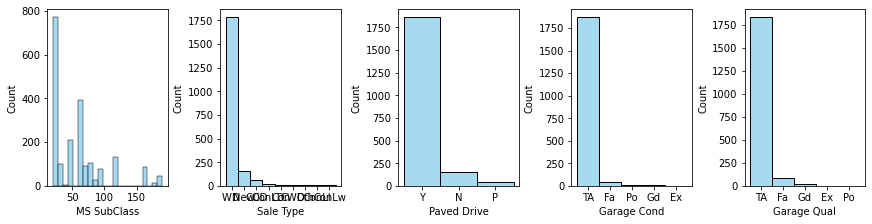

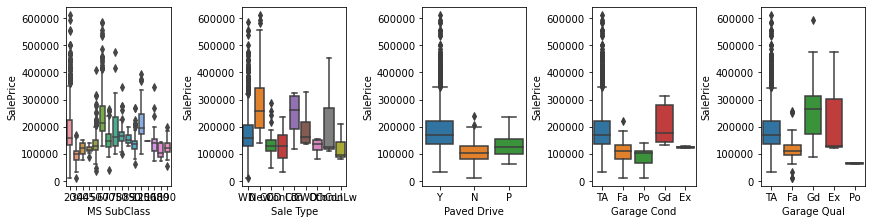

In [39]:
plot_features_catagorical(df,features_catagorical[:5], "SalePrice")

In [40]:
'''
#plot the histogram of each catagorical feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])
      
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])
            
    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])
   
    i +=columns_in_a_row
'''

'\n#plot the histogram of each catagorical feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_catagorical)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs[j])\n      \n    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])\n            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])\n            \n    #sns.pairplot(df, x_vars=features_catagorical[i:min(i+columns_in_a_row,len(features_catagorical))], y_vars=["saleprice"])\n   \n    i +=columns_in_a_row\n'

In [41]:
'''
#plot the histogram of each numeric feature and its pairplot with 'saleprice'
i = 0
columns_in_a_row = 5
while i < (len(features_catagorical)):
    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])
            df[features_catagorical[i+j]].value_counts(dropna=False,sort=False).plot(title=features_catagorical[i+j], kind='bar',ax=axs[j])
       
    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
    for j in range(columns_in_a_row):
        if i+j < (len(features_catagorical)):
            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])
            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])
     
    i +=columns_in_a_row
'''

'\n#plot the histogram of each numeric feature and its pairplot with \'saleprice\'\ni = 0\ncolumns_in_a_row = 5\nwhile i < (len(features_catagorical)):\n    fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            #sns.histplot(data=df, x=features_numeric[i+j], kde=True, color="skyblue", ax=axs[j])\n            df[features_catagorical[i+j]].value_counts(dropna=False,sort=False).plot(title=features_catagorical[i+j], kind=\'bar\',ax=axs[j])\n       \n    fig2, axs2 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))\n    for j in range(columns_in_a_row):\n        if i+j < (len(features_catagorical)):\n            #sns.histplot(data=df, x=features_catagorical[i+j], kde=True, color="skyblue", ax=axs2[j])\n            sns.boxplot(x=features_catagorical[i+j], y="saleprice", data=df, ax=axs2[j])\n     \n    i +=columns_in_a_row\n'

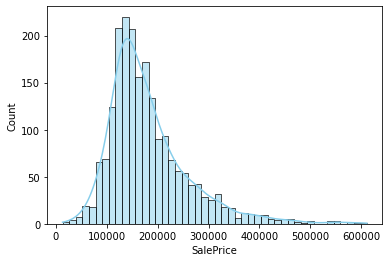

In [42]:
sns.histplot(data=df, x='SalePrice', kde=True, color="skyblue")
plt.show();


In [43]:
from scipy import stats

_, p = stats.normaltest(df['SalePrice'])
print(p)

4.635137528865828e-137


In [44]:
y_sqrt = (df['SalePrice'])**(0.5)
_, p = stats.normaltest(y_sqrt)
print(p)

1.3775989984223007e-49


In [45]:
y_log = np.log(df['SalePrice'])
_, p = stats.normaltest(y_log)
print(p)

3.415079112898754e-22


In [46]:

y_bc, lambda_bc = stats.boxcox(df['SalePrice'])
_, p = stats.normaltest(y_bc)
print(p)

2.3920594213839245e-15


In [47]:
df.describe().T

count           mean           std      min       25%  \
Lot Frontage     1721.0      69.055200     23.260653     21.0      58.0   
Lot Area         2051.0   10065.208191   6742.488909   1300.0    7500.0   
Overall Qual     2051.0       6.112140      1.426271      1.0       5.0   
Overall Cond     2051.0       5.562165      1.104497      1.0       5.0   
Year Built       2051.0    1971.708922     30.177889   1872.0    1953.5   
Year Remod/Add   2051.0    1984.190151     21.036250   1950.0    1964.5   
Mas Vnr Area     2029.0      99.695909    174.963129      0.0       0.0   
BsmtFin SF 1     2050.0     442.300488    461.204124      0.0       0.0   
BsmtFin SF 2     2050.0      47.959024    165.000901      0.0       0.0   
Bsmt Unf SF      2050.0     567.728293    444.954786      0.0     220.0   
Total Bsmt SF    2050.0    1057.987805    449.410704      0.0     793.0   
1st Flr SF       2051.0    1164.488055    396.446923    334.0     879.5   
2nd Flr SF       2051.0     329.329108    425.671046      0.0       0.0   
Low Qual Fin SF  2051.0       5.512921     51.068870      0.0       0.0   
Gr Liv Area      2051.0    1499.330083    500.447829    334.0    1129.0   
Bsmt Full Bath   2049.0       0.427526      0.522673      0.0       0.0   
Bsmt Half Bath   2049.0       0.063446      0.251705      0.0       0.0   
Full Bath        2051.0       1.577279      0.549279      0.0       1.0   
Half Bath        2051.0       0.371039      0.501043      0.0       0.0   
Bedroom AbvGr    2051.0       2.843491      0.826618      0.0       2.0   
Kitchen AbvGr    2051.0       1.042906      0.209790      0.0       1.0   
TotRms AbvGrd    2051.0       6.435885      1.560225      2.0       5.0   
Fireplaces       2051.0       0.590931      0.638516      0.0       0.0   
Garage Yr Blt    1937.0    1978.707796     25.441094   1895.0    1961.0   
Garage Cars      2050.0       1.776585      0.764537      0.0       1.0   
Garage Area      2050.0     473.671707    215.934561      0.0     319.0   
Wood Deck SF     2051.0      93.833740    128.549416      0.0       0.0   
Open Porch SF    2051.0      47.556802     66.747241      0.0       0.0   
Enclosed Porch   2051.0      22.571916     59.845110      0.0       0.0   
3Ssn Porch       2051.0       2.591419     25.229615      0.0       0.0   
Screen Porch     2051.0      16.511458     57.374204      0.0       0.0   
Pool Area        2051.0       2.397855     37.782570      0.0       0.0   
Misc Val         2051.0      51.574354    573.393985      0.0       0.0   
Mo Sold          2051.0       6.219893      2.744736      1.0       4.0   
Yr Sold          2051.0    2007.775719      1.312014   2006.0    2007.0   
SalePrice        2051.0  181469.701609  79258.659352  12789.0  129825.0   

                      50%        75%       max  
Lot Frontage         68.0      80.00     313.0  
Lot Area           9430.0   11513.50  159000.0  
Overall Qual          6.0       7.00      10.0  
Overall Cond          5.0       6.00       9.0  
Year Built         1974.0    2001.00    2010.0  
Year Remod/Add     1993.0    2004.00    2010.0  
Mas Vnr Area          0.0     161.00    1600.0  
BsmtFin SF 1        368.0     733.75    5644.0  
BsmtFin SF 2          0.0       0.00    1474.0  
Bsmt Unf SF         474.5     811.00    2336.0  
Total Bsmt SF       994.5    1318.75    6110.0  
1st Flr SF         1093.0    1405.00    5095.0  
2nd Flr SF            0.0     692.50    1862.0  
Low Qual Fin SF       0.0       0.00    1064.0  
Gr Liv Area        1444.0    1728.50    5642.0  
Bsmt Full Bath        0.0       1.00       3.0  
Bsmt Half Bath        0.0       0.00       2.0  
Full Bath             2.0       2.00       4.0  
Half Bath             0.0       1.00       2.0  
Bedroom AbvGr         3.0       3.00       8.0  
Kitchen AbvGr         1.0       1.00       3.0  
TotRms AbvGrd         6.0       7.00      15.0  
Fireplaces            1.0       1.00       4.0  
Garage Yr Blt      1980.0    2002.00    2207.0  
Garage Cars      

In [48]:
print("garage_yr_blt have wrong max year: 2207")

garage_yr_blt have wrong max year: 2207


In [49]:
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice          1.000000
Overall Qual       0.800207
Gr Liv Area        0.697038
Garage Area        0.650270
Garage Cars        0.648220
Total Bsmt SF      0.628925
1st Flr SF         0.618486
Year Built         0.571849
Year Remod/Add     0.550370
Full Bath          0.537969
Garage Yr Blt      0.533922
Mas Vnr Area       0.512230
TotRms AbvGrd      0.504014
Fireplaces         0.471093
BsmtFin SF 1       0.423519
Lot Frontage       0.341842
Open Porch SF      0.333476
Wood Deck SF       0.326490
Lot Area           0.296566
Bsmt Full Bath     0.283662
Half Bath          0.283001
2nd Flr SF         0.248452
Bsmt Unf SF        0.190210
Bedroom AbvGr      0.137067
Screen Porch       0.134581
3Ssn Porch         0.048732
Mo Sold            0.032735
Pool Area          0.023106
BsmtFin SF 2       0.016255
Misc Val          -0.007375
Yr Sold           -0.015203
Low Qual Fin SF   -0.041594
Bsmt Half Bath    -0.045328
Overall Cond      -0.097019
Kitchen AbvGr     -0.125444
Enclosed Porch    -0

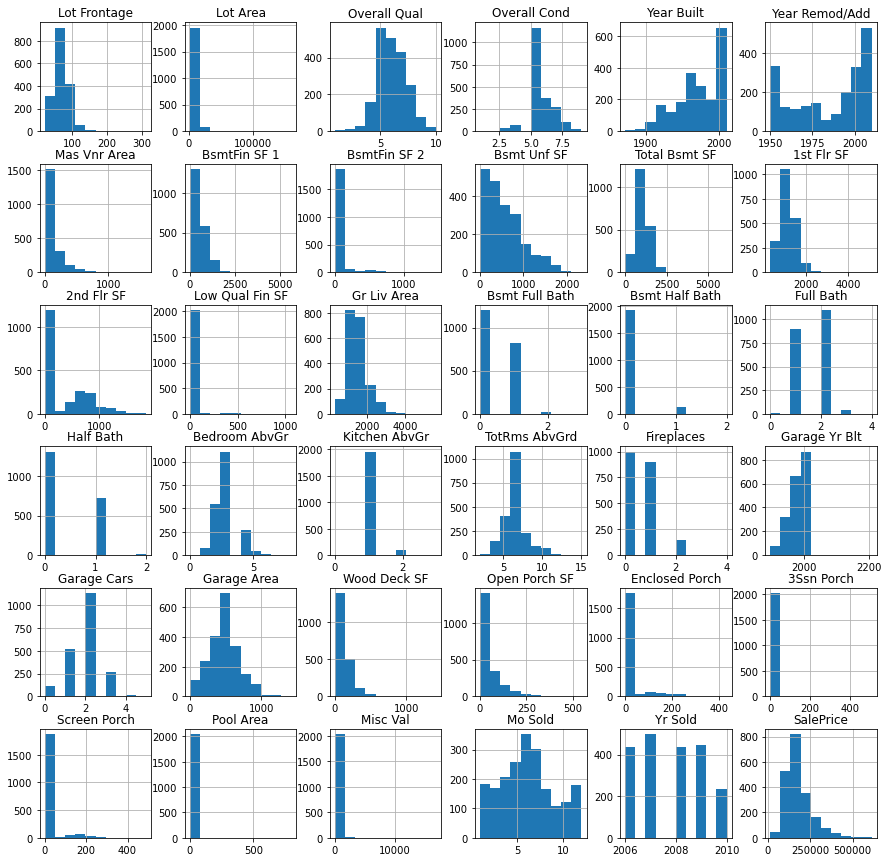

In [50]:
df.hist(figsize=(15, 15));

### EDA: Boxplots

C:\Users\olive\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


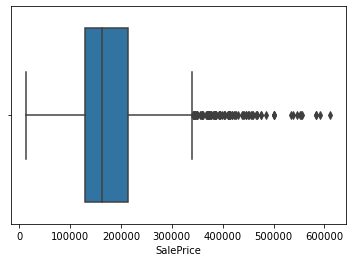

In [51]:
sns.boxplot(df['SalePrice']);

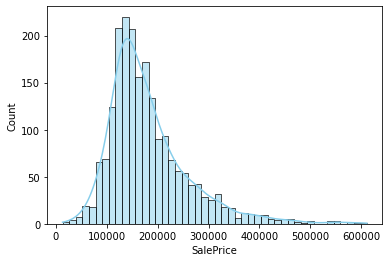

In [52]:
sns.histplot(data=df, x='SalePrice', kde=True, color="skyblue")
plt.show();

### get dummy the catagorical features

In [53]:
df = pd.get_dummies(df, columns=features_catagorical)

In [54]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 292 columns):
 #    Column                Dtype  
---   ------                -----  
 0    Id                    object 
 1    PID                   object 
 2    Misc Feature          object 
 3    Fence                 object 
 4    Pool QC               object 
 5    Fireplace Qu          object 
 6    Alley                 object 
 7    Lot Frontage          float64
 8    Lot Area              int64  
 9    Overall Qual          int64  
 10   Overall Cond          int64  
 11   Year Built            int64  
 12   Year Remod/Add        int64  
 13   Mas Vnr Area          float64
 14   BsmtFin SF 1          float64
 15   BsmtFin SF 2          float64
 16   Bsmt Unf SF           float64
 17   Total Bsmt SF         float64
 18   1st Flr SF            int64  
 19   2nd Flr SF            int64  
 20   Low Qual Fin SF       int64  
 21   Gr Liv Area           int64  
 22   Bsmt Full Bath        

In [55]:
features_dummies = df.columns[-249:]
print(features_dummies)

Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Lot Shape_Reg', 'Street_Grvl', 'Street_Pave', 'MS Zoning_A (agr)',
       'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)',
       'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM'],
      dtype='object', length=249)


### Model Prep: Create our features matrix ( X ) and target vector ( y )

In [56]:
features_final = features_dummies.union(features_numeric,sort=False)
print(features_final)


Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold'],
      dtype='object', length=283)


In [57]:
X = df[features_final]
X.head()

MS SubClass_20  MS SubClass_30  MS SubClass_40  MS SubClass_45  \
0               0               0               0               0   
1               0               0               0               0   
2               1               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MS SubClass_50  MS SubClass_60  MS SubClass_70  MS SubClass_75  \
0               0               1               0               0   
1               0               1               0               0   
2               0               0               0               0   
3               0               1               0               0   
4               1               0               0               0   

   MS SubClass_80  MS SubClass_85  MS SubClass_90  MS SubClass_120  \
0               0               0               0                0   
1               0               0               0                0   
2               0               0               0                0   
3               0               0               0                0   
4               0               0               0                0   

   MS SubClass_150  MS SubClass_160  MS SubClass_180  MS SubClass_190  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Sale Type_COD  Sale Type_CWD  Sale Type_Con  Sale Type_ConLD  \
0              0              0              0                0   
1              0              0              0                0   
2              0              0              0                0   
3              0              0              0                0   
4              0              0              0                0   

   Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  Sale Type_Oth  \
0                0                0              0              0   
1                0                0              0              0   
2                0                0              0              0   
3                0                0              0              0   
4                0                0              0              0   

   Sale Type_WD   Paved Drive_N  Paved Drive_P  Paved Drive_Y  Garage Cond_Ex  \
0              1              0              0              1               0   
1              1              0              0              1               0   
2              1              0              0              1               0   
3              1              0              0              1               0   
4              1              1              0              0               0   

   Garage Cond_Fa  Garage Cond_Gd  Garage Cond_Po  Garage Cond_TA  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               1   
4               0               0               0               1   

   Garage Qual_Ex  Garage Qual_Fa  Garage Qual_Gd  Garage Qual_Po  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Garage Qual_TA  Garage Finish_Fin  Garage Finish_RFn  Garage Finish_Unf  \
0               1                  0                  1                  0   
1               1     

In [58]:
y = df['SalePrice']
y.head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

### fill missing data with mean

In [59]:
X.isnull().sum().sort_values(ascending=False)

Garage Yr Blt           114
Mas Vnr Area             22
Bsmt Full Bath            2
Bsmt Half Bath            2
Garage Cars               1
Garage Area               1
Bsmt Unf SF               1
BsmtFin SF 2              1
BsmtFin SF 1              1
Total Bsmt SF             1
Condition 1_Artery        0
Condition 1_PosN          0
Condition 2_RRNn          0
Condition 1_Feedr         0
Condition 1_Norm          0
Condition 1_PosA          0
Condition 2_RRAn          0
Condition 2_RRAe          0
Condition 2_PosN          0
Condition 2_PosA          0
Condition 2_Norm          0
Condition 2_Feedr         0
MS SubClass_20            0
Condition 1_RRNe          0
Condition 1_RRAe          0
Condition 1_RRAn          0
Neighborhood_Landmrk      0
Neighborhood_IDOTRR       0
Neighborhood_GrnHill      0
Neighborhood_Greens       0
Neighborhood_Gilbert      0
Neighborhood_Edwards      0
Neighborhood_Crawfor      0
Neighborhood_CollgCr      0
Neighborhood_ClearCr      0
Neighborhood_BrkSide

In [60]:
X.fillna(X.mean(),inplace=True)

C:\Users\olive\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [61]:
X.isnull().sum().sort_values(ascending=False)

MS SubClass_20          0
Condition 1_Norm        0
Condition 1_RRNn        0
Condition 1_RRNe        0
Condition 1_RRAn        0
Condition 1_RRAe        0
Condition 1_PosN        0
Condition 1_PosA        0
Condition 1_Feedr       0
Neighborhood_Blueste    0
Condition 1_Artery      0
Condition 2_RRNn        0
Condition 2_RRAn        0
Condition 2_RRAe        0
Condition 2_PosN        0
Condition 2_PosA        0
Neighborhood_Blmngtn    0
Neighborhood_BrDale     0
Neighborhood_NridgHt    0
Neighborhood_IDOTRR     0
Neighborhood_NWAmes     0
Neighborhood_NPkVill    0
Neighborhood_NAmes      0
Neighborhood_Mitchel    0
Neighborhood_MeadowV    0
Neighborhood_Landmrk    0
Neighborhood_GrnHill    0
Neighborhood_BrkSide    0
Neighborhood_Greens     0
Neighborhood_Gilbert    0
Neighborhood_Edwards    0
Neighborhood_Crawfor    0
Neighborhood_CollgCr    0
Neighborhood_ClearCr    0
Condition 2_Norm        0
Condition 2_Feedr       0
Condition 2_Artery      0
Roof Matl_ClyTile       0
Roof Style_F

### Model Prep: Train/test split
We always want to have a holdout set to test our model. Use the train_test_split function to split our X and y variables into a
training set and a holdout set.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [64]:
%%time


# define the pipeline
#scaler = StandardScaler()
#scaler = MinMaxScaler()

is_using_scaler = True
if is_using_scaler :
    scaler = MinMaxScaler()
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)


# Initialze the estimators
model1 = LinearRegression()
model2 = Ridge()
model3 = Lasso()

threhold_perc_diff = 2
best_mse_test = None
best_perc_diff = None
alphas = [0.01, 0.1, 1, 10, 100,1_000,10_000]
best_alpha= None
best_gs = None

for i in range(10):
        # Initialize the hyperparameters for each dictionary
        param1 = {}
        param1['classifier'] = [model1]
        param2 = {}
        param2['classifier__alpha'] = alphas
        param2['classifier'] = [model2]
        param3 = {}
        param3['classifier__alpha'] = alphas
        param3['classifier'] = [model3]

        # create pipeline
        #pipeline = Pipeline(steps=[('scaler', scaler), ('classifier', model1)])
        pipeline = Pipeline(steps=[('classifier', model1)])
        params = [param1, param2, param3]


        # Train the grid search model
        # run GridsearchCV
        gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        if is_using_scaler :
            gs.fit(Z_train, y_train)
        else:
            gs.fit(X_train, y_train)

        # Best performing model and its corresponding hyperparameters
        print('best performing model:', gs.best_params_)

        # MSE score for the best model
        # need to convert to positive
        # https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-
        print('Mse score: ', abs(gs.best_score_))

        # check for generalisation
        if is_using_scaler :
            y_train_pred = gs.predict(Z_train)
            y_test_pred = gs.predict(Z_test)
        else:
            y_train_pred = gs.predict(X_train)
            y_test_pred = gs.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        perc_diff = (mse_train - mse_test)/mse_train * 100
        print('mse of train data: ', mse_train)
        print('mse of test data: ', mse_test)
        print('diff%: ', str(perc_diff)+"%")
        
        temp_best_alpha = gs.best_params_['classifier__alpha']
        alphas = [n*temp_best_alpha/100 for n in range(50, 99)] + [n*temp_best_alpha/100 for n in range(101, 151)] 
        
        if (best_alpha == None 
            or (np.abs(perc_diff) < threhold_perc_diff and (best_mse_test > mse_test))
            ):
             best_mse_test = mse_test
             best_gs = copy.deepcopy(gs)
             best_perc_diff = perc_diff
             best_alpha = temp_best_alpha


best performing model: {'classifier': Ridge(alpha=10), 'classifier__alpha': 10}
Mse score:  937187908.0642482
mse of train data:  628007372.677255
mse of test data:  603358715.555092
diff%:  3.9248993235674114%
best performing model: {'classifier': Ridge(alpha=9.3), 'classifier__alpha': 9.3}
Mse score:  936944597.083717
mse of train data:  622338103.1290655
mse of test data:  601727444.982696
diff%:  3.3118104198892433%
best performing model: {'classifier': Ridge(alpha=9.393), 'classifier__alpha': 9.393}
Mse score:  936949971.3212099
mse of train data:  623103641.7080833
mse of test data:  601940452.0294892
diff%:  3.3964156621810946%
best performing model: {'classifier': Ridge(alpha=9.205140000000002), 'classifier__alpha': 9.205140000000002}
Mse score:  936948229.223739
mse of train data:  621553125.1439406
mse of test data:  601511365.9910703
diff%:  3.224464384798803%
best performing model: {'classifier': Ridge(alpha=9.2971914), 'classifier__alpha': 9.2971914}
Mse score:  936944571.

In [65]:

print('best performing model:', best_gs.best_params_)
# check for generalisation
best_y_train_pred = best_gs.predict(X_train)
best_y_test_pred = best_gs.predict(X_test)


best_mse_train = mean_squared_error(y_train, y_train_pred)
best_mse_test = mean_squared_error(y_test, y_test_pred)
best_perc_diff = (mse_train - mse_test)/mse_train * 100
print('mse of train data: ', mse_train)
print('mse of test data: ', mse_test)
print('diff%: ', str(perc_diff)+"%")
        
       

best performing model: {'classifier': Lasso(alpha=59.66053560974846), 'classifier__alpha': 59.66053560974846}
mse of train data:  494463643.18597955
mse of test data:  495085972.52618814
diff%:  -0.12585947395418862%


In [689]:
coefs = best_gs.best_estimator_.named_steps["classifier"].coef_

In [690]:
"""
coefs_list = sorted(list(zip(features_final,coefs)),reverse=True, key=lambda x: np.abs(x[1]))
for i in coefs_list: 
    print(i)
"""

('roof_matl_ClyTile', -414140.8680330434)
('neighborhood_GrnHill', 67264.85295290376)
('neighborhood_StoneBr', 46523.50190183723)
('roof_matl_WdShngl', 35353.543763068934)
('neighborhood_NoRidge', 31905.300487457374)
('exter_qual_Ex', 31866.29367384054)
('neighborhood_NridgHt', 27146.013303712167)
('kitchen_qual_Ex', 19581.681317092374)
('exterior_1st_BrkFace', 14158.211886174468)
('bldg_type_1Fam', 13587.018506763057)
('neighborhood_Crawfor', 13259.660235852527)
('roof_style_Mansard', -12889.512602039658)
('condition_1_PosN', 12563.43597372949)
('bsmt_exposure_Gd', 12341.441610161846)
('neighborhood_Somerst', 11453.087977094681)
('functional_Maj1', -9686.19503824734)
('neighborhood_Edwards', -9447.278140696133)
('sale_type_New', 9322.233333402157)
('bsmt_qual_Ex', 8884.057070557226)
('mas_vnr_type_BrkCmn', -8742.071668090928)
('land_contour_HLS', 8376.469256799917)
('overall_qual', 8356.179575032469)
('functional_Typ', 7752.615500814012)
('sale_type_COD', -6760.0908177584115)
('garage

In [699]:
df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
df_coefs.columns = ['feature', 'coef']
df_coefs['abs_coef']=np.abs(df_coefs['coef'])

df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
df_coefs.reset_index(drop=True,inplace=True)
df_coefs.head(150)

feature          coef      abs_coef
0       roof_matl_ClyTile -4.141409e+05  4.141409e+05
1    neighborhood_GrnHill  6.726485e+04  6.726485e+04
2    neighborhood_StoneBr  4.652350e+04  4.652350e+04
3       roof_matl_WdShngl  3.535354e+04  3.535354e+04
4    neighborhood_NoRidge  3.190530e+04  3.190530e+04
5           exter_qual_Ex  3.186629e+04  3.186629e+04
6    neighborhood_NridgHt  2.714601e+04  2.714601e+04
7         kitchen_qual_Ex  1.958168e+04  1.958168e+04
8    exterior_1st_BrkFace  1.415821e+04  1.415821e+04
9          bldg_type_1Fam  1.358702e+04  1.358702e+04
10   neighborhood_Crawfor  1.325966e+04  1.325966e+04
11     roof_style_Mansard -1.288951e+04  1.288951e+04
12       condition_1_PosN  1.256344e+04  1.256344e+04
13       bsmt_exposure_Gd  1.234144e+04  1.234144e+04
14   neighborhood_Somerst  1.145309e+04  1.145309e+04
15        functional_Maj1 -9.686195e+03  9.686195e+03
16   neighborhood_Edwards -9.447278e+03  9.447278e+03
17          sale_type_New  9.322233e+03  9.322233e+03
18           bsmt_qual_Ex  8.884057e+03  8.884057e+03
19    mas_vnr_type_BrkCmn -8.742072e+03  8.742072e+03
20       land_contour_HLS  8.376469e+03  8.376469e+03
21           overall_qual  8.356180e+03  8.356180e+03
22         functional_Typ  7.752616e+03  7.752616e+03
23          sale_type_COD -6.760091e+03  6.760091e+03
24         garage_qual_TA -6.447800e+03  6.447800e+03
25     bsmtfin_type_2_GLQ  6.304645e+03  6.304645e+03
26       condition_1_Norm  6.052825e+03  6.052825e+03
27       land_contour_Bnk -6.038975e+03  6.038975e+03
28              full_bath  5.961474e+03  5.961474e+03
29          lot_shape_IR2  5.890420e+03  5.890420e+03
30           bsmt_qual_Gd -5.862557e+03  5.862557e+03
31         bsmt_full_bath  5.801275e+03  5.801275e+03
32     house_style_1Story  5.758886e+03  5.758886e+03
33       bsmt_exposure_Mn -5.666122e+03  5.666122e+03
34          kitchen_abvgr -5.645309e+03  5.645309e+03
35             fireplaces  5.307094e+03  5.307094e+03
36       condition_1_RRAe -5.290115e+03  5.290115e+03
37           overall_cond  5.233449e+03  5.233449e+03
38       bsmt_exposure_No -4.940618e+03  4.940618e+03
39         garage_qual_Gd  4.803494e+03  4.803494e+03
40         garage_qual_Fa -4.726277e+03  4.726277e+03
41   neighborhood_Gilbert -4.523703e+03  4.523703e+03
42     garage_type_2Types -4.415740e+03  4.415740e+03
43     bsmtfin_type_2_ALQ  4.343742e+03  4.343742e+03
44        ms_subclass_120 -4.196023e+03  4.196023e+03
45         roof_style_Hip  3.891643e+03  3.891643e+03
46            garage_cars  3.733064e+03  3.733064e+03
47           heating_GasA  3.573245e+03  3.573245e+03
48          heating_qc_Ex  3.567796e+03  3.567796e+03
49          paved_drive_Y  3.553866e+03  3.553866e+03
50     bsmtfin_type_1_LwQ -3.536289e+03  3.536289e+03
51           bsmt_qual_TA -3.525286e+03  3.525286e+03
52     house_style_2Story -3.513450e+03  3.513450e+03
53      garage_finish_RFn -3.507591e+03  3.507591e+03
54     bsmtfin_type_2_Rec -3.451969e+03  3.451969e+03
55          lot_shape_IR3 -3.344345e+03  3.344345e+03
56   neighborhood_OldTown -3.177465e+03  3.177465e+03
57          exter_qual_TA -3.134678e+03  3.134678e+03
58     bsmtfin_type_1_GLQ  3.018848e+03  3.018848e+03
59              half_bath  2.943008e+03  2.943008e+03
60         lot_config_FR2 -2.691325e+03  2.691325e+03
61     lot_config_CulDSac  2.627001e+03  2.627001e+03
62     condition_1_Artery -2.460069e+03  2.460069e+03
63         land_slope_Mod  2.354749e+03  2.354749e+03
64     mas_vnr_type_Stone  2.343796e+03  2.343796e+03
65     neighborhood_NAmes -2.315771e+03  2.315771e+03
66   exterior_2nd_Plywood -2.276313e+03  2.276313e+03
67   exterior_1st_HdBoard -2.216538e+03  2.216538e+03
68    garage_type_BuiltIn  2.173554e+03  2.173554e+03
69    neighborhood_NWAmes -2.152354e+03  2.152354e+03
70          sale_type_WD  -2.131594e+03  2.131594e+03
71   neighborhood_BrkSide  2.110988e+03  2.110988e+03
72       foundation_PConc  2.044138e+03  2.044138e+03
73   exterior_1st_Viny

# Multicollinearity

In [159]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                  feature         VIF
0                lot_area    3.229927
1            overall_qual    6.150540
2            overall_cond    2.737041
3              year_built   17.901058
4          year_remod/add    3.990474
5            mas_vnr_area    3.171225
6            bsmtfin_sf_1         inf
7            bsmtfin_sf_2         inf
8             bsmt_unf_sf         inf
9           total_bsmt_sf         inf
10             1st_flr_sf         inf
11             2nd_flr_sf         inf
12        low_qual_fin_sf         inf
13            gr_liv_area         inf
14         bsmt_full_bath    2.713863
15         bsmt_half_bath    1.449874
16              full_bath    4.077185
17              half_bath    2.890186
18          bedroom_abvgr    3.333105
19          kitchen_abvgr    4.918167
20          totrms_abvgrd    6.084003
21             fireplaces    2.201143
22          garage_yr_blt    5.492629
23            garage_cars    9.730312
24            garage_area    9.009234
25          

In [163]:
df_coefs = pd.DataFrame(coefs_list)
df_coefs.columns = ["feature", 'coefs']
df_lr_params = pd.merge(left = df_coefs,
                        right = vif_data, 
                        on ="feature" )

df_lr_params.sort_values(by=['coefs'],ascending=False,inplace=True)
df_lr_params.reset_index(inplace=True,drop=True)
df_lr_params.head(100)

feature         coefs        VIF
0   neighborhood_GrnHill  66286.413858        inf
1   neighborhood_StoneBr  46357.763285        inf
2      roof_matl_WdShngl  34597.904324        inf
3          exter_qual_Ex  31791.814638        inf
4   neighborhood_NoRidge  31734.034901        inf
5   neighborhood_NridgHt  27079.708110        inf
6        kitchen_qual_Ex  19714.467298        inf
7   exterior_1st_BrkFace  14186.934758        inf
8         bldg_type_1Fam  13588.164758        inf
9   neighborhood_Crawfor  13277.761323        inf
10      condition_1_PosN  12539.201665        inf
11      bsmt_exposure_Gd  12300.843232  48.914469
12  neighborhood_Somerst  11472.328657        inf
13         sale_type_New   9351.099895        inf
14          bsmt_qual_Ex   8859.157948        inf
15          overall_qual   8401.147674   6.150540
16        functional_Typ   7689.579878        inf
17      land_contour_HLS   7664.121855        inf
18    bsmtfin_type_2_GLQ   6079.956854  19.689192
19      condition_1_Norm   6074.867293        inf
20             full_bath   5863.662667   4.077185
21        bsmt_full_bath   5830.637685   2.713863
22         lot_shape_IR2   5811.921537        inf
23    house_style_1Story   5511.467986        inf
24            fireplaces   5287.568557   2.201143
25          overall_cond   5262.798563   2.737041
26        garage_qual_Gd   4629.091559        inf
27    bsmtfin_type_2_ALQ   4284.356256  27.764505
28        roof_style_Hip   3938.241470        inf
29           garage_cars   3728.119927   9.730312
30         paved_drive_Y   3623.368029        inf
31         heating_qc_Ex   3573.759819        inf
32          heating_GasA   3245.327398        inf
33    bsmtfin_type_1_GLQ   2967.035517        inf
34             half_bath   2846.358498   2.890186
35    lot_config_CulDSac   2603.586778        inf
36        land_slope_Mod   2343.173386        inf
37    mas_vnr_type_Stone   2286.892105   8.057842
38  neighborhood_BrkSide   2106.847950        inf
39   garage_type_BuiltIn   2079.375486        inf
40      foundation_PConc   2030.358734        inf
41  exterior_1st_VinylSd   2014.044021        inf
42    garage_type_Attchd   1736.580438        inf
43        ms_subclass_30   1595.696670        inf
44         totrms_abvgrd   1536.721328   6.084003
45  exterior_2nd_MetalSd   1172.231923        inf
46       functional_Min1   1010.038739        inf
47  exterior_2nd_Wd Sdng    870.821075        inf
48    bsmtfin_type_1_ALQ    808.534246        inf
49     mas_vnr_type_None    787.113581  25.195627
50        garage_cond_TA    710.818768        inf
51          bsmt_cond_TA    634.417415        inf
52         central_air_N    420.013813        inf
53          ms_zoning_RL    378.578047        inf
54            year_built    280.261944  17.901058
55       kitchen_qual_Gd    210.912027        inf
56  neighborhood_Blmngtn    192.726501        inf
57     garage_finish_Fin    118.046750        inf
58               yr_sold     84.801385   1.266828
59          screen_porch     78.427799   1.361798
60        year_remod/add     75.670252   3.990474
61         garage_yr_blt     47.441032   5.492629
62            2nd_flr_sf     39.391465        inf
63            3ssn_porch     35.150350   1.204712
64            1st_flr_sf     27.962092        inf
65       low_qual_fin_sf     25.922339        inf
66          bsmtfin_sf_1     20.179333        inf
67        enclosed_porch     16.553727   1.633600
68          mas_vnr_area     15.941485   3.171225
69          bsmtfin_sf_2     14.367762        inf
70          wood_deck_sf     11.480511   1.588845
71           garage_area     10.811844   9.009234
72           bsmt_unf_sf      8.633329        inf
73      land_contour_Lvl      7.962032        inf
74           gr_liv_area      6.988816        inf
75         total_bsmt_sf      5.229039        inf
76         open_porch_sf      4.573749   1.643637
77              lot_area      0.814876   3.229927
78          ms_zoning_FV      0.118415        inf
79    exterior_1s

# LINE Assumptions

In [ ]:
# L - Linearity

In [ ]:
# I - Independence

In [ ]:
# N - Normality of errors
plt.hist(resids, bins=50);

In [ ]:
# E - Equal variance of errors
plt.scatter(y_pred, resids, s=1)
plt.axhline(0, color="orange");

# testing the kaggle output

In [799]:
# read the files
df_test = pd.read_csv("../datasets/test.csv")
df_test.head().T

0          1          2          3          4
Id                    2658       2718       2414       1989        625
PID              902301120  905108090  528218130  902207150  535105100
MS SubClass            190         90         60         30         20
MS Zoning               RM         RL         RL         RM         RL
Lot Frontage          69.0        NaN       58.0       60.0        NaN
Lot Area              9142       9662      17104       8520       9500
Street                Pave       Pave       Pave       Pave       Pave
Alley                 Grvl        NaN        NaN        NaN        NaN
Lot Shape              Reg        IR1        IR1        Reg        IR1
Land Contour           Lvl        Lvl        Lvl        Lvl        Lvl
Utilities           AllPub     AllPub     AllPub     AllPub     AllPub
Lot Config          Inside     Inside     Inside     Inside     Inside
Land Slope             Gtl        Gtl        Gtl        Gtl        Gtl
Neighborhood       OldTown     Sawyer    Gilbert    OldTown      NAmes
Condition 1           Norm       Norm       Norm       Norm       Norm
Condition 2           Norm       Norm       Norm       Norm       Norm
Bldg Type           2fmCon     Duplex       1Fam       1Fam       1Fam
House Style         2Story     1Story     2Story     1Story     1Story
Overall Qual             6          5          7          5          6
Overall Cond             8          4          5          6          5
Year Built            1910       1977       2006       1923       1963
Year Remod/Add        1950       1977       2006       2006       1963
Roof Style           Gable      Gable      Gable      Gable      Gable
Roof Matl          CompShg    CompShg    CompShg    CompShg    CompShg
Exterior 1st       AsbShng    Plywood    VinylSd    Wd Sdng    Plywood
Exterior 2nd       AsbShng    Plywood    VinylSd    Wd Sdng    Plywood
Mas Vnr Type          None       None       None       None    BrkFace
Mas Vnr Area           0.0        0.0        0.0        0.0      247.0
Exter Qual              TA         TA         Gd         Gd         TA
Exter Cond              Fa         TA         TA         TA         TA
Foundation           Stone     CBlock      PConc     CBlock     CBlock
Bsmt Qual               Fa         Gd         Gd         TA         Gd
Bsmt Cond               TA         TA         Gd         TA         TA
Bsmt Exposure           No         No         Av         No         No
BsmtFin Type 1         Unf        Unf        GLQ        Unf        BLQ
BsmtFin SF 1             0          0        554          0        609
BsmtFin Type 2         Unf        Unf        Unf        Unf        Unf
BsmtFin SF 2             0          0          0          0          0
Bsmt Unf SF           1020       1967        100        968        785
Total Bsmt SF         1020       1967        654        968       1394
Heating               GasA       GasA       GasA       GasA       GasA
Heating QC              Gd         TA         Ex         TA         Gd
Central Air              N          Y          Y          Y          Y
Electrical           FuseP      SBrkr      SBrkr      SBrkr      SBrkr
1st Flr SF             908       1967        664        968       1394
2nd Flr SF            1020          0        832          0          0
Low Qual Fin SF          0          0          0          0          0
Gr Liv Area           1928       1967       1496        968       1394
Bsmt Full Bath           0          0          1          0          1
Bsmt Half Bath           0          0          0          0          0
Full Bath                2          2          2          1          1
Half Bath                0          0          1          0          1
Bedroom AbvGr            4          6          3          2          3
Kitchen AbvGr            2          2          1          1          1
Kitchen Qual            Fa         TA         Gd         TA         TA
TotRms AbvGrd            9         10          7 

In [800]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

### after comparing the data directory and dataframe Dtypes, and found the following columns need to convert to string type
- id
- pid
- ms_subclass

In [801]:
#rename column
#df.columns=df.columns.str.lower()
#df.columns=df.columns.str.replace(" ","_")
#change column type, according to data directory
str_type_columns=["Id", "PID","MS SubClass"]
for column in str_type_columns:
    df_test[column]=df_test[column].astype("object")

In [802]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    object 
 1   PID              878 non-null    object 
 2   MS SubClass      878 non-null    object 
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [803]:
#rearrange the columns such that all feature of 'object' type will be moved before all numeric 

columns_copy = df_test.columns.tolist()
for column in columns_copy:
    if df_test[column].dtype == object:
        column_to_reorder = df_test.pop(column)
        df_test.insert(3, column, column_to_reorder)
   # else:
    #    df2.insert(-1, df.columns[i], column_to_reorder)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    object 
 1   PID              878 non-null    object 
 2   MS SubClass      878 non-null    object 
 3   Sale Type        878 non-null    object 
 4   Misc Feature     41 non-null     object 
 5   Fence            172 non-null    object 
 6   Pool QC          4 non-null      object 
 7   Paved Drive      878 non-null    object 
 8   Garage Cond      833 non-null    object 
 9   Garage Qual      833 non-null    object 
 10  Garage Finish    833 non-null    object 
 11  Garage Type      834 non-null    object 
 12  Fireplace Qu     456 non-null    object 
 13  Functional       878 non-null    object 
 14  Kitchen Qual     878 non-null    object 
 15  Electrical       877 non-null    object 
 16  Central Air      878 non-null    object 
 17  Heating QC      

In [754]:
print("from above, we can see: column #2 to #44 are of catagorical features  ")
print("from above, we can see: column #44 and above are of numeric features  ")

from above, we can see: column #2 to #44 are of catagorical features  
from above, we can see: column #44 and above are of numeric features  


In [806]:
features_catagorical_test = df_test.columns[2:45]
print(features_catagorical_test)

features_numeric_test = df_test.columns[45:-1]
print(features_numeric_test)

Index(['MS SubClass', 'Sale Type', 'Misc Feature', 'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Garage Type', 'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical', 'Central Air', 'Heating QC', 'Heating', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Foundation', 'Exter Cond', 'Exter Qual', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Land Slope', 'Lot Config', 'Utilities', 'Land Contour',
       'Lot Shape', 'Alley', 'Street', 'MS Zoning'],
      dtype='object')
Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt H

## checking null values

In [807]:
(df_test.isnull().sum()/len(df_test)).sort_values(ascending=False)

Pool QC            0.995444
Misc Feature       0.953303
Alley              0.933941
Fence              0.804100
Fireplace Qu       0.480638
Lot Frontage       0.182232
Garage Yr Blt      0.051253
Garage Cond        0.051253
Garage Qual        0.051253
Garage Finish      0.051253
Garage Type        0.050114
Bsmt Cond          0.028474
Bsmt Exposure      0.028474
BsmtFin Type 1     0.028474
BsmtFin Type 2     0.028474
Bsmt Qual          0.028474
Mas Vnr Type       0.001139
Electrical         0.001139
Mas Vnr Area       0.001139
Gr Liv Area        0.000000
Bsmt Full Bath     0.000000
Low Qual Fin SF    0.000000
Bsmt Half Bath     0.000000
Id                 0.000000
Bsmt Unf SF        0.000000
2nd Flr SF         0.000000
1st Flr SF         0.000000
Total Bsmt SF      0.000000
Half Bath          0.000000
BsmtFin SF 2       0.000000
BsmtFin SF 1       0.000000
Full Bath          0.000000
Garage Area        0.000000
Bedroom AbvGr      0.000000
Kitchen AbvGr      0.000000
TotRms AbvGrd      0

we will not consider the following features with too many null value:

|feature|null value %|
------------------------------
Pool QC            0.995612

Misc Feature       0.968308

Alley              0.931741

Fence              0.804973

Fireplace Qu       0.487567

Lot Frontage       0.160897

In [808]:
features_numeric_test=features_numeric_test.drop('Lot Frontage')
print(features_numeric_test)

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars',
       'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold'],
      dtype='object')


In [809]:
features_catagorical_test=features_catagorical_test.drop(['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu'])
print(features_catagorical_test)

Index(['MS SubClass', 'Sale Type', 'Paved Drive', 'Garage Cond', 'Garage Qual',
       'Garage Finish', 'Garage Type', 'Functional', 'Kitchen Qual',
       'Electrical', 'Central Air', 'Heating QC', 'Heating', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Foundation', 'Exter Cond', 'Exter Qual', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Neighborhood', 'Land Slope', 'Lot Config', 'Utilities', 'Land Contour',
       'Lot Shape', 'Street', 'MS Zoning'],
      dtype='object')


In [811]:
df_test = pd.get_dummies(df_test, columns=features_catagorical_test)

In [812]:
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 275 columns):
 #    Column                Dtype  
---   ------                -----  
 0    Id                    object 
 1    PID                   object 
 2    Misc Feature          object 
 3    Fence                 object 
 4    Pool QC               object 
 5    Fireplace Qu          object 
 6    Alley                 object 
 7    Lot Frontage          float64
 8    Lot Area              int64  
 9    Overall Qual          int64  
 10   Overall Cond          int64  
 11   Year Built            int64  
 12   Year Remod/Add        int64  
 13   Mas Vnr Area          float64
 14   BsmtFin SF 1          int64  
 15   BsmtFin SF 2          int64  
 16   Bsmt Unf SF           int64  
 17   Total Bsmt SF         int64  
 18   1st Flr SF            int64  
 19   2nd Flr SF            int64  
 20   Low Qual Fin SF       int64  
 21   Gr Liv Area           int64  
 22   Bsmt Full Bath        in

In [814]:
features_dummies_test = df_test.columns[-233:]
print(features_dummies_test)

Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Lot Shape_IR3', 'Lot Shape_Reg', 'Street_Grvl', 'Street_Pave',
       'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)',
       'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM'],
      dtype='object', length=233)


### Model Prep: Create our features matrix ( X ) and target vector ( y )

In [817]:
features_final_test = features_dummies_test.union(features_numeric_test,sort=False)
print(features_final_test)


Index(['MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45',
       'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75',
       'MS SubClass_80', 'MS SubClass_85',
       ...
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold'],
      dtype='object', length=266)


In [818]:
X_kaggle = df_test[features_final_test]
X_kaggle.head()

MS SubClass_20  MS SubClass_30  MS SubClass_40  MS SubClass_45  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               1               0               0   
4               1               0               0               0   

   MS SubClass_50  MS SubClass_60  MS SubClass_70  MS SubClass_75  \
0               0               0               0               0   
1               0               0               0               0   
2               0               1               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MS SubClass_80  MS SubClass_85  MS SubClass_90  MS SubClass_120  \
0               0               0               0                0   
1               0               0               1                0   
2               0               0               0                0   
3               0               0               0                0   
4               0               0               0                0   

   MS SubClass_160  MS SubClass_180  MS SubClass_190  Sale Type_COD  \
0                0                0                1              0   
1                0                0                0              0   
2                0                0                0              0   
3                0                0                0              0   
4                0                0                0              0   

   Sale Type_CWD  Sale Type_Con  Sale Type_ConLD  Sale Type_ConLI  \
0              0              0                0                0   
1              0              0                0                0   
2              0              0                0                0   
3              0              0                0                0   
4              0              0                0                0   

   Sale Type_ConLw  Sale Type_New  Sale Type_Oth  Sale Type_VWD  \
0                0              0              0              0   
1                0              0              0              0   
2                0              1              0              0   
3                0              0              0              0   
4                0              0              0              0   

   Sale Type_WD   Paved Drive_N  Paved Drive_P  Paved Drive_Y  Garage Cond_Ex  \
0              1              0              0              1               0   
1              1              0              0              1               0   
2              0              0              0              1               0   
3              1              1              0              0               0   
4              1              0              0              1               0   

   Garage Cond_Fa  Garage Cond_Gd  Garage Cond_Po  Garage Cond_TA  \
0               0               0               1               0   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               1   
4               0               0               0               1   

   Garage Qual_Fa  Garage Qual_Gd  Garage Qual_Po  Garage Qual_TA  \
0               0               0               1               0   
1               0               0               0               1   
2               0               0               0               1   
3               1               0               0               0   
4               0               0               0               1   

   Garage Finish_Fin  Garage Finish_RFn  Garage Finish_Unf  \
0                  0                  0                  1   
1                  1                  0                  0   
2   

### fill missing data with mean

In [819]:
X_kaggle.isnull().sum().sort_values(ascending=False)

Garage Yr Blt           45
Mas Vnr Area             1
MS SubClass_20           0
Condition 1_Norm         0
Condition 1_RRNe         0
Condition 1_RRAn         0
Condition 1_RRAe         0
Condition 1_PosN         0
Condition 1_PosA         0
Condition 1_Feedr        0
Neighborhood_Blmngtn     0
Condition 1_Artery       0
Condition 2_PosA         0
Condition 2_Norm         0
Condition 2_Feedr        0
Bldg Type_TwnhsE         0
Condition 1_RRNn         0
Neighborhood_Blueste     0
Bldg Type_Duplex         0
Neighborhood_BrDale      0
Neighborhood_BrkSide     0
Neighborhood_ClearCr     0
Neighborhood_CollgCr     0
Neighborhood_Crawfor     0
Neighborhood_Edwards     0
Neighborhood_Gilbert     0
Neighborhood_Greens      0
Neighborhood_IDOTRR      0
Neighborhood_MeadowV     0
Neighborhood_Mitchel     0
Neighborhood_NAmes       0
Neighborhood_NPkVill     0
Neighborhood_NWAmes      0
Bldg Type_Twnhs          0
Bldg Type_1Fam           0
Bldg Type_2fmCon         0
Neighborhood_NridgHt     0
E

In [821]:
X_kaggle.fillna(X.mean(),inplace=True)
X_kaggle.isnull().sum().sort_values(ascending=False)

MS SubClass_20          0
Neighborhood_Blueste    0
Bldg Type_TwnhsE        0
Condition 2_Feedr       0
Condition 2_Norm        0
Condition 2_PosA        0
Condition 1_Artery      0
Condition 1_Feedr       0
Condition 1_Norm        0
Condition 1_PosA        0
Condition 1_PosN        0
Condition 1_RRAe        0
Condition 1_RRAn        0
Condition 1_RRNe        0
Condition 1_RRNn        0
Neighborhood_Blmngtn    0
Neighborhood_BrDale     0
Neighborhood_OldTown    0
Neighborhood_BrkSide    0
Neighborhood_ClearCr    0
Neighborhood_CollgCr    0
Neighborhood_Crawfor    0
Neighborhood_Edwards    0
Neighborhood_Gilbert    0
Neighborhood_Greens     0
Neighborhood_IDOTRR     0
Neighborhood_MeadowV    0
Neighborhood_Mitchel    0
Neighborhood_NAmes      0
Neighborhood_NPkVill    0
Neighborhood_NWAmes     0
Neighborhood_NoRidge    0
Bldg Type_Twnhs         0
Bldg Type_Duplex        0
Bldg Type_2fmCon        0
Bldg Type_1Fam          0
Exterior 1st_CemntBd    0
Exterior 1st_HdBoard    0
Exterior 1st

#  producing kaggle prediction

In [823]:
y_kaggle_pred = best_gs.predict(X_kaggle)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 283 is different from 266)